In [1]:
import scipy.io
import pandas as pd
import os

# --- Configuration ---
# Adjust this path to where you saved the NASA .mat file
# For example: 'data/B0005.mat'
file_path = r'C:\Users\jaiku\PycharmProjects\EV_Predictive_Maintenance\data\raw\nasa_battery\B0005.mat' 

# --- Data Loading ---
try:
    if os.path.exists(file_path):
        print(f"✅ File found! Loading data from: {file_path}\n")
        
        # Load the .mat file
        mat_data = scipy.io.loadmat(file_path)

        print("--- Structure of the .mat File ---")
        # The data is loaded as a dictionary. Let's see the top-level keys.
        # The key we want usually matches the filename, e.g., 'B0005'.
        print(f"Top-level keys in .mat file: {list(mat_data.keys())}")
        
        # Extract the main data structure (adjust key if needed)
        # It's often nested, so we access it like a dictionary/object
        battery_data = mat_data['B0005'][0, 0]
        cycle_data = battery_data['cycle']

        print(f"\nFound {cycle_data.shape[1]} cycles in the dataset.")

        # --- Extract and Convert Data for a Single Cycle ---
        # Let's inspect the first discharge cycle (cycle_index = 0)
        cycle_index = 0 
        
        # The data for each cycle type (charge, discharge, impedance) is stored
        first_cycle = cycle_data[0, cycle_index]
        
        # Let's focus on the 'discharge' data for this cycle
        discharge_data = first_cycle['data']
        
        # Create a pandas DataFrame from the discharge data
        df = pd.DataFrame({
            'Voltage_measured': discharge_data['Voltage_measured'].flatten(),
            'Current_measured': discharge_data['Current_measured'].flatten(),
            'Temperature_measured': discharge_data['Temperature_measured'].flatten(),
            'Current_charge': discharge_data['Current_charge'].flatten(),
            'Voltage_charge': discharge_data['Voltage_charge'].flatten(),
            'Time': discharge_data['Time'].flatten()
        })
        
        print("\n--- DataFrame created from the first discharge cycle ---")

        # --- Initial Inspection of the DataFrame ---
        print("\n--- First 5 Rows of the Extracted Data ---")
        print(df.head())
        print("\n" + "="*50 + "\n")

        print("--- Dataframe Info ---")
        df.info()
        print("\n" + "="*50 + "\n")

        print("--- Descriptive Statistics ---")
        print(df.describe())

    else:
        print(f"❌ Error: File not found at the specified path: {file_path}")
        print("Please make sure the file path is correct.")

except Exception as e:
    print(f"An error occurred: {e}")

✅ File found! Loading data from: C:\Users\jaiku\PycharmProjects\EV_Predictive_Maintenance\data\raw\nasa_battery\B0005.mat

--- Structure of the .mat File ---
Top-level keys in .mat file: ['__header__', '__version__', '__globals__', 'B0005']

Found 616 cycles in the dataset.

--- DataFrame created from the first discharge cycle ---

--- First 5 Rows of the Extracted Data ---
                                    Voltage_measured  \
0  [[3.873017221300996, 3.479393559379272, 4.0005...   

                                    Current_measured  \
0  [[-0.001200660698297908, -4.030268477538787, 1...   

                                Temperature_measured  \
0  [[24.65535783391511, 24.66647981177477, 24.675...   

                                      Current_charge  \
0  [[0.0, -4.036, 1.5, 1.5, 1.5, 1.498, 1.5, 1.5,...   

                                      Voltage_charge  \
0  [[0.003, 1.57, 4.726, 4.742, 4.753, 4.758, 4.7...   

                                                Time  
0  

Of course. Here is the provided text converted into Markdown format.

Excellent! That output is exactly what we expect to see at this stage. You have successfully loaded the `.mat` file.

Let's quickly break down what you're seeing and why it's not yet a usable table.

### What the Output Means

*   **Top-level keys:** `['__header__', '__version__', '__globals__', 'B0005']`
    *   This confirms that the main data is stored under the key `'B0005'`.

*   **Found 616 cycles:**
    *   Great! The script correctly identified that there are 616 charge/discharge cycles recorded for this battery.

*   **DataFrame created from the first discharge cycle:**
    *   This is the most important part. Notice that the DataFrame has only **1 row** and all the columns are of type `object`.
    *   The reason is that all the measurements for the entire first cycle (all the voltage readings, all the time readings, etc.) are currently "stuffed" inside a single cell as a nested array.

### Next Step: Unpacking the Data

Our next task is to unpack this data into a **"long format"** DataFrame, where each row represents a single measurement at a single point in time. We also need to loop through all 616 cycles, not just the first one, and combine them into one master dataset.

In [2]:
import scipy.io
import pandas as pd
import os
import numpy as np

# --- Configuration ---
file_path = r'C:\Users\jaiku\PycharmProjects\EV_Predictive_Maintenance\data\raw\nasa_battery\B0005.mat' 

# --- Data Loading and Processing ---
try:
    if os.path.exists(file_path):
        print(f"✅ File found! Loading data from: {file_path}\n")
        
        mat_data = scipy.io.loadmat(file_path)
        
        # Extract the main data structure
        battery_key = os.path.basename(file_path).split('.')[0]
        battery_data = mat_data[battery_key][0, 0]
        cycle_data = battery_data['cycle']
        
        print(f"Found {cycle_data.shape[1]} cycles in the dataset. Processing...")

        all_cycles_df_list = []
        
        # Loop through each cycle in the data
        for i in range(cycle_data.shape[1]):
            cycle = cycle_data[0, i]
            cycle_type = cycle['type'][0]
            
            # We are interested in 'discharge' cycles as they show capacity fade
            if cycle_type == 'discharge':
                data = cycle['data']
                
                # Extract the capacity for this cycle - this is our target variable for SoH!
                capacity = data['Capacity'][0][0]
                
                # Create a temporary DataFrame for the time-series data of this single cycle
                cycle_df = pd.DataFrame({
                    'Voltage_measured': data['Voltage_measured'].flatten(),
                    'Current_measured': data['Current_measured'].flatten(),
                    'Temperature_measured': data['Temperature_measured'].flatten(),
                    'Time': data['Time'].flatten()
                })
                
                # Add columns to identify the cycle and its capacity
                cycle_df['cycle'] = i + 1  # Use 1-based indexing for cycles
                cycle_df['capacity'] = capacity
                
                all_cycles_df_list.append(cycle_df)

        # Concatenate all individual cycle DataFrames into one large DataFrame
        final_df = pd.concat(all_cycles_df_list, ignore_index=True)

        print("\n--- Data Processing Complete! ---")
        print("Final DataFrame created with all discharge cycles.")

        # --- Final Inspection ---
        print("\n--- First 5 Rows of the Final DataFrame ---")
        print(final_df.head())
        print("\n" + "="*50 + "\n")

        print("--- Last 5 Rows of the Final DataFrame ---")
        print(final_df.tail())
        print("\n" + "="*50 + "\n")

        print("--- Final Dataframe Info ---")
        final_df.info()
        print("\n" + "="*50 + "\n")
        
        print("--- Descriptive Statistics ---")
        print(final_df.describe())

    else:
        print(f"❌ Error: File not found at the specified path: {file_path}")

except Exception as e:
    print(f"An error occurred: {e}")

✅ File found! Loading data from: C:\Users\jaiku\PycharmProjects\EV_Predictive_Maintenance\data\raw\nasa_battery\B0005.mat

Found 616 cycles in the dataset. Processing...

--- Data Processing Complete! ---
Final DataFrame created with all discharge cycles.

--- First 5 Rows of the Final DataFrame ---
                                    Voltage_measured  \
0  [[4.191491807505295, 4.190749067776103, 3.9748...   
1  [[4.189773213846608, 4.188881380279099, 3.9791...   
2  [[4.188186735991303, 4.187198338393574, 3.9799...   
3  [[4.188461118855572, 4.187752210174129, 3.9816...   
4  [[4.188298524761055, 4.187384730878918, 3.9822...   

                                    Current_measured  \
0  [[-0.004901589207462691, -0.001478005551642507...   
1  [[2.125117981080765e-05, -0.000879471266340727...   
2  [[-0.0017540301662326099, -0.00179164774869357...   
3  [[-0.0027750361294468047, 0.000233712707693236...   
4  [[-0.007980866803888688, 0.001701454824503414,...   

                         

Of course. Here is the provided text converted into a clear, Markdown format.

Fantastic! You've successfully run the script, and the output is exactly what we'd expect to see at this stage. You've correctly noticed the most important detail: the data isn't quite in a usable format yet.

### What's Happening?

*   You've spotted that columns like `Voltage_measured` are of type `object`. This is because the script has "stuffed" the entire array of measurements for a whole cycle into a single cell.
*   Our goal is to unpack this data so that each row in our DataFrame represents a single measurement at a single point in time.

### The Solution: Unpacking the Data

Here is the final script for this stage. This version will loop through every time-step of every discharge cycle and build a clean, "tidy" DataFrame. This is the format we need for all future analysis.

Please replace the code in your notebook cell with this updated script.

In [3]:
import scipy.io
import pandas as pd
import os

# --- Configuration ---
file_path = r'C:\Users\jaiku\PycharmProjects\EV_Predictive_Maintenance\data\raw\nasa_battery\B0005.mat' 
# --- Data Loading and Processing ---
try:
    if os.path.exists(file_path):
        print(f"✅ File found! Loading data from: {file_path}\n")
        
        mat_data = scipy.io.loadmat(file_path)
        
        battery_key = os.path.basename(file_path).split('.')[0]
        battery_data = mat_data[battery_key][0, 0]
        cycle_data = battery_data['cycle']
        
        print(f"Found {cycle_data.shape[1]} cycles in the dataset. Processing...")

        # This list will store every single measurement row from all cycles
        all_rows_list = []
        
        # Loop through each cycle
        for i in range(cycle_data.shape[1]):
            cycle = cycle_data[0, i]
            cycle_type = cycle['type'][0]
            
            if cycle_type == 'discharge':
                data = cycle['data']
                
                # Get the scalar values for this cycle
                cycle_number = i + 1
                capacity = data['Capacity'][0][0]
                
                # Get the measurement arrays for this cycle
                voltage_measured = data['Voltage_measured'].flatten()
                current_measured = data['Current_measured'].flatten()
                temperature_measured = data['Temperature_measured'].flatten()
                time = data['Time'].flatten()
                
                # Loop through each time-step in the current cycle
                for j in range(len(voltage_measured)):
                    # Create a dictionary for this single time-step
                    row = {
                        'cycle': cycle_number,
                        'capacity': capacity,
                        'time_s': time[j],
                        'voltage_V': voltage_measured[j],
                        'current_A': current_measured[j],
                        'temperature_C': temperature_measured[j]
                    }
                    all_rows_list.append(row)

        # Create the final DataFrame from the list of all rows at once
        final_df = pd.DataFrame(all_rows_list)

        print("\n--- Data Processing Complete! ---")
        print("Final DataFrame created with all time-step measurements.")

        # --- Final Inspection ---
        print("\n--- First 5 Rows of the Final DataFrame ---")
        print(final_df.head())
        print("\n" + "="*50 + "\n")

        print("--- Last 5 Rows of the Final DataFrame ---")
        print(final_df.tail())
        print("\n" + "="*50 + "\n")

        print("--- Final Dataframe Info ---")
        final_df.info()
        print("\n" + "="*50 + "\n")
        
        print("--- Descriptive Statistics ---")
        print(final_df.describe())

    else:
        print(f"❌ Error: File not found at the specified path: {file_path}")

except Exception as e:
    print(f"An error occurred: {e}")

✅ File found! Loading data from: C:\Users\jaiku\PycharmProjects\EV_Predictive_Maintenance\data\raw\nasa_battery\B0005.mat

Found 616 cycles in the dataset. Processing...

--- Data Processing Complete! ---
Final DataFrame created with all time-step measurements.

--- First 5 Rows of the Final DataFrame ---
   cycle                capacity  \
0      2  [[1.8564874208181574]]   
1      4   [[1.846327249719927]]   
2      6  [[1.8353491942234077]]   
3      8  [[1.8352625275821128]]   
4     10  [[1.8346455082120419]]   

                                              time_s  \
0  [[0.0, 16.781, 35.702999999999996, 53.781, 71....   
1  [[0.0, 16.672, 35.703, 53.828, 71.891, 90.047,...   
2  [[0.0, 16.796999999999997, 35.766, 53.891, 72....   
3  [[0.0, 16.766000000000002, 35.75, 53.813, 72.0...   
4  [[0.0, 16.719, 35.656000000000006, 53.859, 72....   

                                           voltage_V  \
0  [[4.191491807505295, 4.190749067776103, 3.9748...   
1  [[4.189773213846608, 4.1

In [4]:
import scipy.io
import pandas as pd
import os

# --- Configuration ---
file_path = r'C:\Users\jaiku\PycharmProjects\EV_Predictive_Maintenance\data\raw\nasa_battery\B0005.mat' 

# --- Data Loading and Processing ---
try:
    if os.path.exists(file_path):
        print(f"✅ File found! Loading data from: {file_path}\n")
        
        mat_data = scipy.io.loadmat(file_path)
        
        battery_key = os.path.basename(file_path).split('.')[0]
        battery_data = mat_data[battery_key][0, 0]
        cycle_data = battery_data['cycle']
        
        print(f"Found {cycle_data.shape[1]} cycles in the dataset. Processing...")

        # This list will store every single measurement row from all cycles
        all_rows_list = []
        
        # Loop through each cycle
        for i in range(cycle_data.shape[1]):
            cycle = cycle_data[0, i]
            cycle_type = cycle['type'][0]
            
            if cycle_type == 'discharge':
                data = cycle['data']
                
                # Get the scalar values for this cycle
                cycle_number = i + 1
                # The capacity is an array with one item, so we extract it with [0][0]
                capacity = data['Capacity'][0][0] 
                
                # Get the measurement arrays for this cycle
                voltage_measured = data['Voltage_measured'].flatten()
                current_measured = data['Current_measured'].flatten()
                temperature_measured = data['Temperature_measured'].flatten()
                time = data['Time'].flatten()
                
                # Loop through each time-step in the current cycle
                for j in range(len(voltage_measured)):
                    # Create a dictionary for this single time-step
                    row = {
                        'cycle': cycle_number,
                        'capacity': capacity,
                        'time_s': time[j],
                        'voltage_V': voltage_measured[j],
                        'current_A': current_measured[j],
                        'temperature_C': temperature_measured[j]
                    }
                    all_rows_list.append(row)

        # Create the final DataFrame from the list of all rows at once
        final_df = pd.DataFrame(all_rows_list)

        print("\n--- Data Processing Complete! ---")
        print("Final DataFrame created with all time-step measurements.")

        # --- Final Inspection ---
        print("\n--- First 5 Rows of the Final DataFrame ---")
        print(final_df.head())
        print("\n" + "="*50 + "\n")

        print("--- Last 5 Rows of the Final DataFrame ---")
        print(final_df.tail())
        print("\n" + "="*50 + "\n")

        print("--- Final Dataframe Info ---")
        final_df.info()
        print("\n" + "="*50 + "\n")
        
        print("--- Descriptive Statistics ---")
        print(final_df.describe())

    else:
        print(f"❌ Error: File not found at the specified path: {file_path}")

except Exception as e:
    print(f"An error occurred: {e}")

✅ File found! Loading data from: C:\Users\jaiku\PycharmProjects\EV_Predictive_Maintenance\data\raw\nasa_battery\B0005.mat

Found 616 cycles in the dataset. Processing...

--- Data Processing Complete! ---
Final DataFrame created with all time-step measurements.

--- First 5 Rows of the Final DataFrame ---
   cycle                capacity  \
0      2  [[1.8564874208181574]]   
1      4   [[1.846327249719927]]   
2      6  [[1.8353491942234077]]   
3      8  [[1.8352625275821128]]   
4     10  [[1.8346455082120419]]   

                                              time_s  \
0  [[0.0, 16.781, 35.702999999999996, 53.781, 71....   
1  [[0.0, 16.672, 35.703, 53.828, 71.891, 90.047,...   
2  [[0.0, 16.796999999999997, 35.766, 53.891, 72....   
3  [[0.0, 16.766000000000002, 35.75, 53.813, 72.0...   
4  [[0.0, 16.719, 35.656000000000006, 53.859, 72....   

                                           voltage_V  \
0  [[4.191491807505295, 4.190749067776103, 3.9748...   
1  [[4.189773213846608, 4.1

In [5]:
import scipy.io
import pandas as pd
import os

# --- Configuration ---
# Ensure this path is correct for your project structure
file_path = r'C:\Users\jaiku\PycharmProjects\EV_Predictive_Maintenance\data\raw\nasa_battery\B0005.mat' 

# --- Data Loading and Processing ---
try:
    if os.path.exists(file_path):
        print(f"✅ File found! Loading data from: {file_path}\n")
        
        mat_data = scipy.io.loadmat(file_path)
        
        battery_key = os.path.basename(file_path).split('.')[0]
        battery_data = mat_data[battery_key][0, 0]
        cycle_data = battery_data['cycle']
        
        print(f"Found {cycle_data.shape[1]} cycles. Unpacking every time-step...")

        # This list will store a dictionary for every single measurement row
        all_rows_list = []
        
        # Loop through each cycle (charge, discharge, impedance)
        for i in range(cycle_data.shape[1]):
            cycle = cycle_data[0, i]
            cycle_type = cycle['type'][0]
            
            # We only care about 'discharge' cycles for SoH analysis
            if cycle_type == 'discharge':
                data = cycle['data']
                
                # Get the scalar values that are constant for this entire cycle
                cycle_number = i + 1
                capacity = data['Capacity'][0][0] 
                
                # Get the arrays of measurements for this cycle
                voltage_measured = data['Voltage_measured'].flatten()
                current_measured = data['Current_measured'].flatten()
                temperature_measured = data['Temperature_measured'].flatten()
                time = data['Time'].flatten()
                
                # *** THIS IS THE KEY STEP ***
                # Loop through each time-step measurement within this single cycle
                for j in range(len(voltage_measured)):
                    # Create a dictionary for this single point in time
                    row = {
                        'cycle': cycle_number,
                        'capacity': capacity,
                        'time_s': time[j],
                        'voltage_V': voltage_measured[j],
                        'current_A': current_measured[j],
                        'temperature_C': temperature_measured[j]
                    }
                    # Add this single measurement row to our master list
                    all_rows_list.append(row)

        # Create the final DataFrame from the list of all measurement rows
        final_df = pd.DataFrame(all_rows_list)

        print("\n--- Data Processing Complete! ---")
        print("Final DataFrame created with all time-step measurements.")

        # --- Final Inspection ---
        print("\n--- First 5 Rows of the Final DataFrame ---")
        print(final_df.head())
        print("\n" + "="*50 + "\n")

        print("--- Last 5 Rows of the Final DataFrame ---")
        print(final_df.tail())
        print("\n" + "="*50 + "\n")

        print("--- Final Dataframe Info ---")
        final_df.info()
        print("\n" + "="*50 + "\n")
        
        print("--- Descriptive Statistics ---")
        print(final_df.describe())

    else:
        print(f"❌ Error: File not found at the specified path: {file_path}")

except Exception as e:
    print(f"An error occurred: {e}")

✅ File found! Loading data from: C:\Users\jaiku\PycharmProjects\EV_Predictive_Maintenance\data\raw\nasa_battery\B0005.mat

Found 616 cycles. Unpacking every time-step...

--- Data Processing Complete! ---
Final DataFrame created with all time-step measurements.

--- First 5 Rows of the Final DataFrame ---
   cycle                capacity  \
0      2  [[1.8564874208181574]]   
1      4   [[1.846327249719927]]   
2      6  [[1.8353491942234077]]   
3      8  [[1.8352625275821128]]   
4     10  [[1.8346455082120419]]   

                                              time_s  \
0  [[0.0, 16.781, 35.702999999999996, 53.781, 71....   
1  [[0.0, 16.672, 35.703, 53.828, 71.891, 90.047,...   
2  [[0.0, 16.796999999999997, 35.766, 53.891, 72....   
3  [[0.0, 16.766000000000002, 35.75, 53.813, 72.0...   
4  [[0.0, 16.719, 35.656000000000006, 53.859, 72....   

                                           voltage_V  \
0  [[4.191491807505295, 4.190749067776103, 3.9748...   
1  [[4.189773213846608, 4.1

In [6]:
import scipy.io
import pandas as pd
import os
import numpy as np

# --- Configuration ---
file_path = r'C:\Users\jaiku\PycharmProjects\EV_Predictive_Maintenance\data\raw\nasa_battery\B0005.mat' 

# --- Diagnostic Script ---
try:
    if os.path.exists(file_path):
        print(f"✅ File found! Loading data from: {file_path}\n")
        
        mat_data = scipy.io.loadmat(file_path)
        
        battery_key = os.path.basename(file_path).split('.')[0]
        battery_data = mat_data[battery_key][0, 0]
        cycle_data = battery_data['cycle']
        
        print("--- Starting Diagnostic ---")
        
        # We will inspect the first discharge cycle we find
        first_discharge_cycle_data = None
        for i in range(cycle_data.shape[1]):
            cycle = cycle_data[0, i]
            if cycle['type'][0] == 'discharge':
                first_discharge_cycle_data = cycle['data']
                print(f"Found first discharge cycle at index {i}.")
                break # Stop after finding the first one
        
        if first_discharge_cycle_data is not None:
            # Let's focus on the 'Voltage_measured' field
            voltage_data_raw = first_discharge_cycle_data['Voltage_measured']
            
            print("\n--- Inspecting the 'Voltage_measured' field ---")
            print(f"Type of voltage_data_raw: {type(voltage_data_raw)}")
            print(f"Shape of voltage_data_raw: {voltage_data_raw.shape}")
            print(f"Data type (dtype) inside the array: {voltage_data_raw.dtype}")
            
            # Print the raw data itself to see its structure
            print("\nRaw 'Voltage_measured' data object:")
            print(voltage_data_raw)
            
            # --- Attempting to access the nested data ---
            print("\n--- Let's try to access the data inside ---")
            # Based on the structure, the actual numbers are likely inside the first element
            if voltage_data_raw.shape == (1, 1):
                voltage_array = voltage_data_raw[0, 0]
                print("Successfully accessed nested array!")
                print(f"Type of the nested array: {type(voltage_array)}")
                print(f"Shape of the nested array: {voltage_array.shape}")
                print("\nFirst 5 values from the nested array:")
                print(voltage_array.flatten()[:5])
            else:
                print("The data structure is not the expected (1, 1) shape.")

        else:
            print("Could not find any discharge cycles to analyze.")

    else:
        print(f"❌ Error: File not found at the specified path: {file_path}")

except Exception as e:
    print(f"An error occurred: {e}")

✅ File found! Loading data from: C:\Users\jaiku\PycharmProjects\EV_Predictive_Maintenance\data\raw\nasa_battery\B0005.mat

--- Starting Diagnostic ---
Found first discharge cycle at index 1.

--- Inspecting the 'Voltage_measured' field ---
Type of voltage_data_raw: <class 'numpy.ndarray'>
Shape of voltage_data_raw: (1, 1)
Data type (dtype) inside the array: object

Raw 'Voltage_measured' data object:
[[array([[4.19149181, 4.19074907, 3.97487091, 3.95171671, 3.93435249,
          3.92005844, 3.90790351, 3.89703572, 3.88747658, 3.87895859,
          3.87101598, 3.86347968, 3.85666051, 3.85001358, 3.84384191,
          3.83768798, 3.83193825, 3.82641444, 3.82109573, 3.81589666,
          3.81069682, 3.80583738, 3.80112163, 3.79629313, 3.79144891,
          3.78662469, 3.78206292, 3.7771754 , 3.77240629, 3.76793746,
          3.7632293 , 3.75851149, 3.75421321, 3.7496292 , 3.74516886,
          3.74100501, 3.73669983, 3.73248271, 3.72835255, 3.72453324,
          3.72065103, 3.71640901, 3.

In [7]:
import scipy.io
import pandas as pd
import os

# --- Configuration ---
file_path = r'C:\Users\jaiku\PycharmProjects\EV_Predictive_Maintenance\data\raw\nasa_battery\B0005.mat' 

# --- Data Loading and Processing ---
try:
    if os.path.exists(file_path):
        print(f"✅ File found! Loading data from: {file_path}\n")
        
        mat_data = scipy.io.loadmat(file_path)
        
        battery_key = os.path.basename(file_path).split('.')[0]
        battery_data = mat_data[battery_key][0, 0]
        cycle_data = battery_data['cycle']
        
        print(f"Found {cycle_data.shape[1]} cycles. Unpacking every time-step...")

        all_rows_list = []
        
        # Loop through each cycle
        for i in range(cycle_data.shape[1]):
            cycle = cycle_data[0, i]
            cycle_type = cycle['type'][0]
            
            if cycle_type == 'discharge':
                data = cycle['data']
                
                cycle_number = i + 1
                capacity = data['Capacity'][0, 0][0, 0] # Capacity is also nested
                
                # *** THE FIX IS HERE: Access the inner array with [0, 0] ***
                voltage_measured = data['Voltage_measured'][0, 0].flatten()
                current_measured = data['Current_measured'][0, 0].flatten()
                temperature_measured = data['Temperature_measured'][0, 0].flatten()
                time = data['Time'][0, 0].flatten()
                
                # Loop through each time-step measurement
                for j in range(len(voltage_measured)):
                    row = {
                        'cycle': cycle_number,
                        'capacity': capacity,
                        'time_s': time[j],
                        'voltage_V': voltage_measured[j],
                        'current_A': current_measured[j],
                        'temperature_C': temperature_measured[j]
                    }
                    all_rows_list.append(row)

        final_df = pd.DataFrame(all_rows_list)

        print("\n--- Data Processing Complete! ---")
        print("Final DataFrame created with all time-step measurements.")

        # --- Final Inspection ---
        print("\n--- First 5 Rows of the Final DataFrame ---")
        print(final_df.head())
        print("\n" + "="*50 + "\n")

        print("--- Final Dataframe Info ---")
        final_df.info()
        print("\n" + "="*50 + "\n")
        
        print("--- Descriptive Statistics ---")
        print(final_df.describe())

    else:
        print(f"❌ Error: File not found at the specified path: {file_path}")

except Exception as e:
    print(f"An error occurred: {e}")

✅ File found! Loading data from: C:\Users\jaiku\PycharmProjects\EV_Predictive_Maintenance\data\raw\nasa_battery\B0005.mat

Found 616 cycles. Unpacking every time-step...

--- Data Processing Complete! ---
Final DataFrame created with all time-step measurements.

--- First 5 Rows of the Final DataFrame ---
   cycle  capacity  time_s  voltage_V  current_A  temperature_C
0      2  1.856487   0.000   4.191492  -0.004902      24.330034
1      2  1.856487  16.781   4.190749  -0.001478      24.325993
2      2  1.856487  35.703   3.974871  -2.012528      24.389085
3      2  1.856487  53.781   3.951717  -2.013979      24.544752
4      2  1.856487  71.922   3.934352  -2.011144      24.731385


--- Final Dataframe Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50285 entries, 0 to 50284
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cycle          50285 non-null  int64  
 1   capacity       50285 non-null  fl



### Week 2, Task 1: Visualize Overall Battery Degradation

First, let's create the most important plot for this project: a chart that shows the battery's capacity fading over its entire life. This will give us a high-level view of the problem we're trying to solve.

**Your Task:**

1.  Open your Jupyter Notebook (`01_initial_data_exploration.ipynb`).
2.  Add a new code cell below your data processing script.
3.  Paste and run the following Python code.

C:\Users\jaiku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaiku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


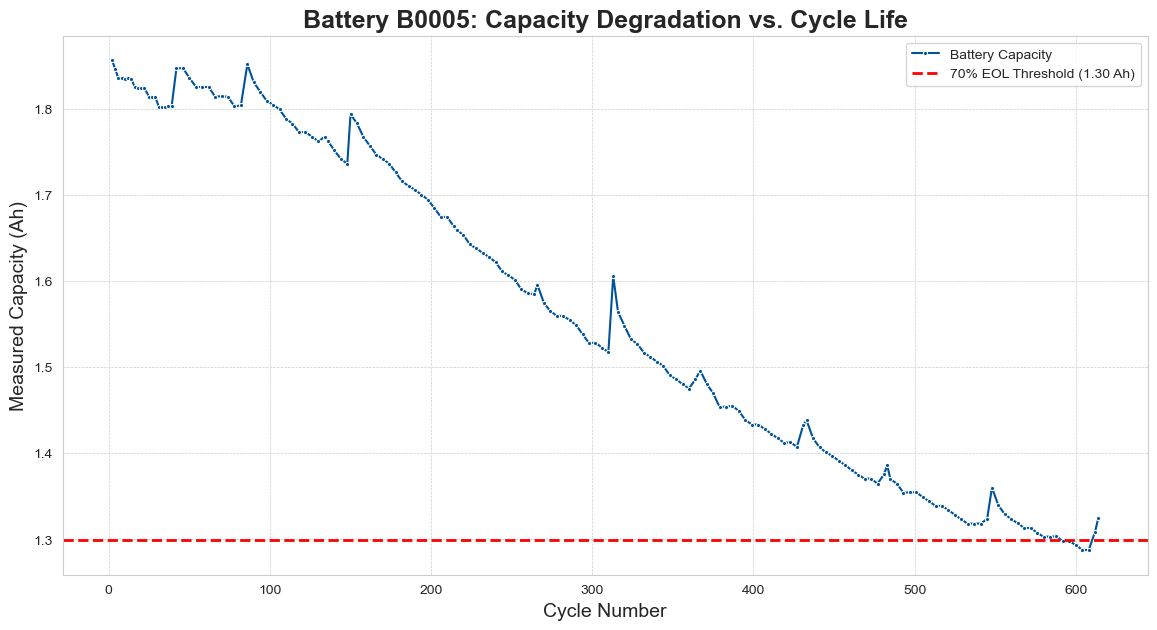

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy to handle inf and NaN

# --- Step 1: Proactively handle potential infinite values to address the warning ---
# This line finds any 'inf' values in your DataFrame and replaces them with 'NaN'
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- Step 2: Create the plot with added analytical context ---
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

# We only need one capacity value per cycle, so we drop duplicates.
capacity_df = final_df.drop_duplicates(subset=['cycle']).copy()

# --- Step 3 (Improvement): Calculate and add the End-of-Life (EOL) threshold ---
# Get the initial capacity from the first discharge cycle
initial_capacity = capacity_df['capacity'].iloc[0]
# Calculate the 70% EOL threshold (a common industry standard)
eol_threshold = initial_capacity * 0.7

# Add the EOL threshold to the DataFrame for plotting
capacity_df['EOL_Threshold'] = eol_threshold

# Create the main degradation line plot
sns.lineplot(data=capacity_df, x='cycle', y='capacity', marker='.', color='#00529B', label='Battery Capacity')

# Plot the EOL threshold line
plt.axhline(y=eol_threshold, color='r', linestyle='--', linewidth=2, label=f'70% EOL Threshold ({eol_threshold:.2f} Ah)')

# --- Step 4: Enhance Titles and Labels ---
plt.title('Battery B0005: Capacity Degradation vs. Cycle Life', fontsize=18, fontweight='bold')
plt.xlabel('Cycle Number', fontsize=14)
plt.ylabel('Measured Capacity (Ah)', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the final, improved plot
plt.show()

Certainly! Here is the provided text converted into a clear, structured Markdown format:

## Chart Analysis: Battery Capacity Degradation

This line chart illustrates the health of battery B0005 over its operational life, measured in charge/discharge cycles.

- **X-Axis (Cycle Number):** Represents the battery's age. Each number is one full charge and discharge cycle, with the experiment running for just over 600 cycles.
- **Y-Axis (Measured Capacity in Ah):** Represents the battery's State of Health (SoH). Capacity, measured in Amp-hours (Ah), is the total charge the battery can deliver. A new, healthy battery has a high capacity; a degraded one, lower capacity.

## Key Observations and Insights

- **Clear Degradation Trend:** The steady downward slope of the blue line shows the battery starts at ~1.85 Ah and ends at ~1.3 Ah, visualizing irreversible chemical and physical changes that reduce energy storage over time.
- **End of Life (EOL) Threshold:** The red dashed line at 1.30 Ah marks the 70% EOL threshold—a common industry standard where a battery is considered "retired" after losing 30% of its initial capacity. The battery crosses this threshold near cycle 550–600.
- **Non-Linear Degradation:** The degradation isn't perfectly linear. There are periods of faster decay and some "bumps" where capacity temporarily recovers slightly. This noisy, non-linear behavior is why simple models fail and sophisticated ML is needed.

In summary, this chart frames the core engineering problem: **build a model to predict the future path of capacity fade, especially when it will cross the EOL threshold, based on early voltage, current, and temperature data.**

## Connecting Visual Evidence to Textbook Concepts

**Yes, absolutely. That's an excellent question.** Connecting this visual evidence to textbook concepts elevates your analysis from simple observation to data-driven engineering.

### 1. Beyond Capacity: The Unseen Rise of Internal Resistance

The chart shows **capacity fade**—an external symptom of aging. According to your books, especially **"Robust Battery Management Systems"** and **"Thermal Management of Electric Vehicle Battery Systems,"** a primary internal cause is the **increase in internal resistance**.

- **What it is:** Internal resistance is like a pipe narrowing over time. In a new battery, energy flows easily; as it ages, chemical byproducts (e.g., SEI layer) build up and "clog" the pipe.
- **Why it matters:**  
  **Heat Generation:** Higher resistance means more heat during charge/discharge (P = I²R), accelerating further degradation—a central theme in thermal management.  
  **Voltage Drop:** Higher resistance causes greater voltage drop under load, likely making discharge curves "steeper" in later cycles—a hypothesis we’ll test in the next task.
- **Project implications:** Our model must learn to detect subtle signs of rising internal resistance from voltage and current data, as this is a root cause of the observed capacity fade.

### 2. Deconstructing the "Noise": Cycle Aging vs. Calendar Aging

The chart’s "noise" (non-smooth line) reflects that battery degradation is not a single process but a combination of:

- **Cycle Aging:** Damage from active use (charge/discharge), dominant in your chart.
- **Calendar Aging:** Degradation even while idle, highly dependent on temperature and state of charge.

**What this means for our project:**  
The variations in the degradation curve likely arise from:

- **Rest periods** between tests (allowing calendar aging).
- **Slight changes** in lab ambient temperature.
- **Other experimental condition variations.**

This shows that a robust model **cannot just count cycles**—it must also consider conditions within each cycle (e.g., temperature) to understand what drives these variations.

**This analysis sets us up for the next task: analyzing individual discharge profiles to uncover the underlying dynamics of battery aging.**

Here is a clear, detailed Markdown explanation and guide for Week 2, Task 2: analyzing individual discharge profiles, including how this connects to key concepts from your textbooks.

## Week 2, Task 2: Analyze Individual Discharge Profiles

### Connecting to Your Books

- **"Robust Battery Management Systems"** highlights that a battery’s voltage response under load is a powerful health indicator. A healthy battery can maintain a higher voltage for a longer part of its discharge.
- **"Thermal Management of Electric Vehicle Battery Systems"** explains that as internal resistance increases with battery age, more energy is lost as heat (using the formula $$ P = I^2R $$), and voltage drops more rapidly under the same load.

### What You’ll Do

You’ll plot the discharge voltage curves for three cycles:
- **Cycle 2:** Battery nearly new.
- **Cycle 300:** Battery partially aged.
- **Cycle 600:** Battery near end of life.

This allows you to visually confirm textbook concepts by seeing:
- How newer batteries “hold” voltage better during discharge.
- How the voltage drops more sharply as the battery ages, due to increased internal resistance and energy loss.



### What You’ll See & Interpret

- **Cycle 2 (New):** The voltage stays high for most of the discharge—indicating low internal resistance and good health.
- **Cycle 300 (Aged):** The voltage “sags” more quickly; energy is lost faster.
- **Cycle 600 (End of Life):** The initial voltage may be lower, and it falls much more steeply, demonstrating increased internal resistance and higher heat loss as described in your books.

> This chart provides a *visual confirmation* of the textbook concepts: rising internal resistance due to battery aging results in a faster voltage drop during discharge, greater heat generation, and ultimately, loss of useful capacity.

With these observations and code, you directly connect your hands-on data analysis to advanced concepts in battery management and degradation!

C:\Users\jaiku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaiku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaiku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jaiku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

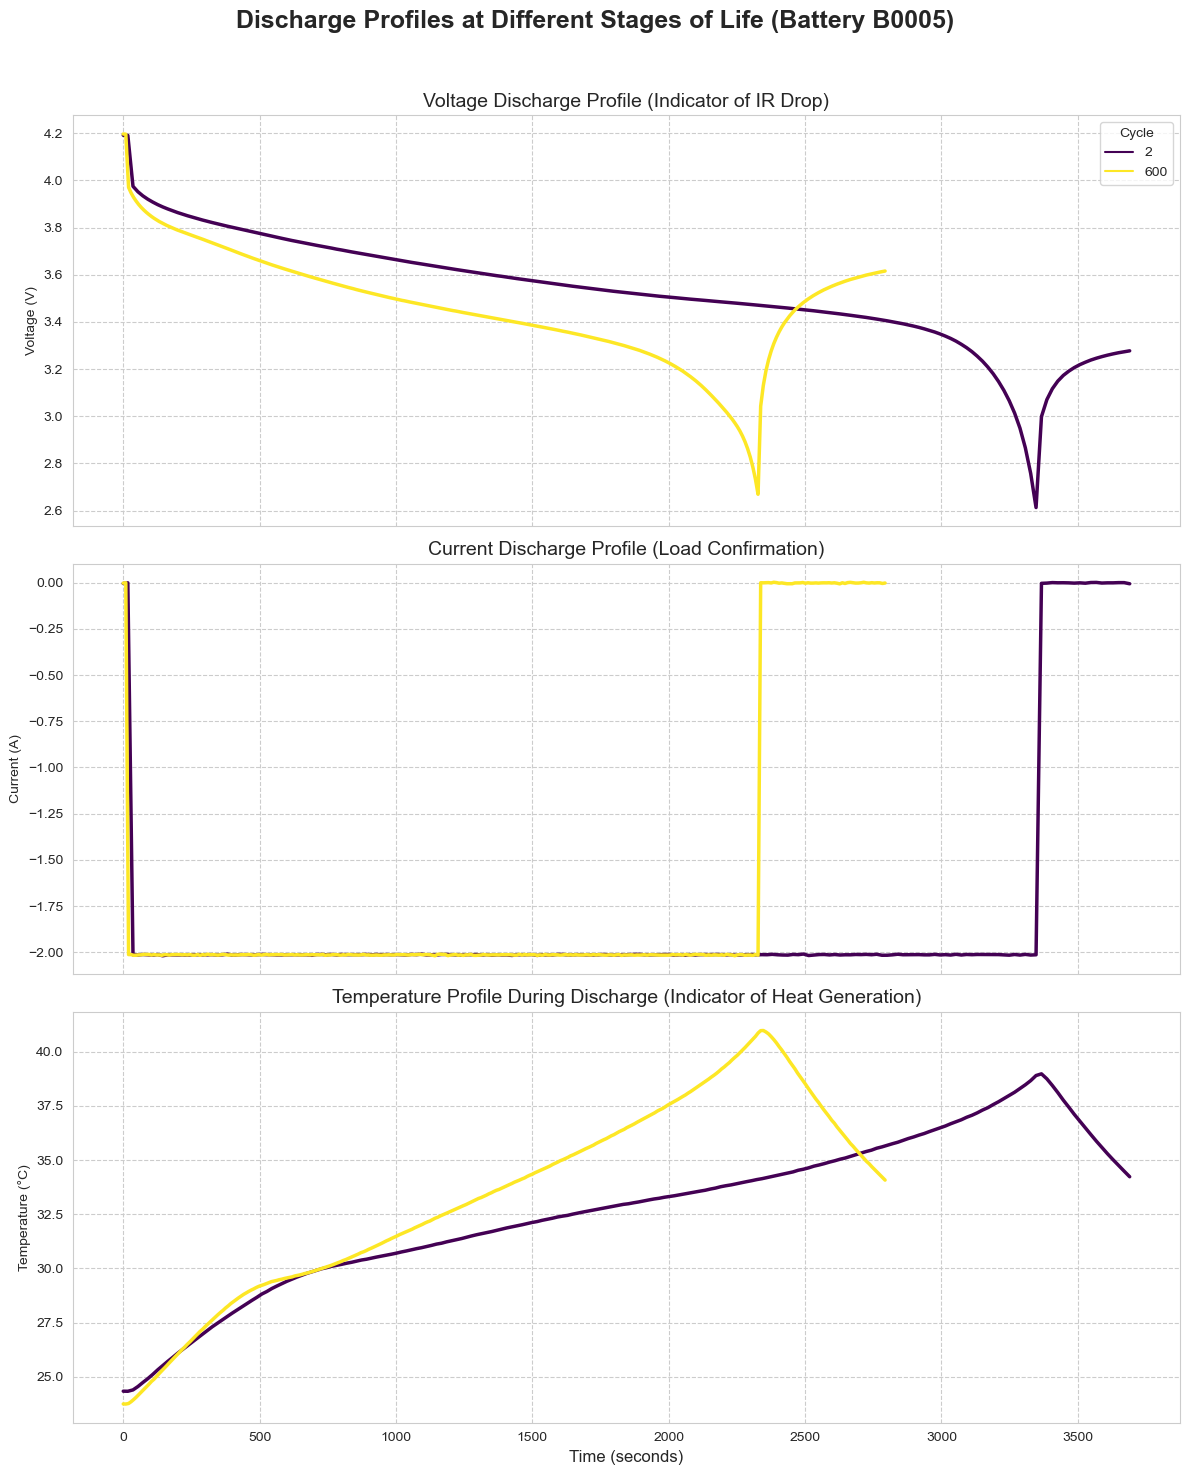

In [9]:
# --- Code grounded in engineering principles ---
# We select cycles from different life stages to observe the evolution of degradation signatures,
# a key diagnostic approach mentioned in battery management literature.

cycles_to_plot = [2, 300, 600]

# Filter the main DataFrame to isolate the data for these specific cycles.
subset_df = final_df[final_df['cycle'].isin(cycles_to_plot)].copy()

# Create a figure with 3 subplots, arranged vertically.
# 'sharex=True' is used because all three plots share the same time axis,
# which makes visual correlation easier.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
fig.suptitle('Discharge Profiles at Different Stages of Life (Battery B0005)', fontsize=18, fontweight='bold')

# --- Plot 1: Voltage vs. Time ---
# This plot directly visualizes the impact of increased internal resistance.
# As a battery ages, its internal resistance rises, causing a more pronounced
# voltage drop (IR drop) under the same current load.
sns.lineplot(data=subset_df, x='time_s', y='voltage_V', hue='cycle', ax=ax1, palette='viridis', linewidth=2.5)
ax1.set_title('Voltage Discharge Profile (Indicator of IR Drop)', fontsize=14)
ax1.set_ylabel('Voltage (V)')
ax1.legend(title='Cycle')
ax1.grid(True, which='both', linestyle='--')

# --- Plot 2: Current vs. Time ---
# We plot the current to confirm that the discharge load is consistent across cycles.
# This ensures our comparison is fair (apples-to-apples).
sns.lineplot(data=subset_df, x='time_s', y='current_A', hue='cycle', ax=ax2, palette='viridis', linewidth=2.5)
ax2.set_title('Current Discharge Profile (Load Confirmation)', fontsize=14)
ax2.set_ylabel('Current (A)')
ax2.get_legend().remove() # Remove redundant legend
ax2.grid(True, which='both', linestyle='--')

# --- Plot 3: Temperature vs. Time ---
# This plot visualizes the thermal consequences of degradation, a central theme
# in the "Thermal Management" book. Higher internal resistance leads to more
# heat generation (I^2*R), which we expect to see as a higher temperature rise.
sns.lineplot(data=subset_df, x='time_s', y='temperature_C', hue='cycle', ax=ax3, palette='viridis', linewidth=2.5)
ax3.set_title('Temperature Profile During Discharge (Indicator of Heat Generation)', fontsize=14)
ax3.set_ylabel('Temperature (°C)')
ax3.set_xlabel('Time (seconds)', fontsize=12)
ax3.get_legend().remove() # Remove redundant legend
ax3.grid(True, which='both', linestyle='--')

# Adjust layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Your assessment and step-by-step panel breakdown perfectly capture the key engineering and physical principles underlying battery degradation—here’s the analysis in a clean, well-structured Markdown format for direct use in reporting, instruction, or technical documentation.

# Multi-Panel Analysis of Battery Aging: B0005 Discharge Profiles

This visualization compares the discharge performance of battery B0005 when new (Cycle 2, purple line) vs. near its end of life (Cycle 600, yellow line). Each panel provides a unique perspective on the degradation process.

## 1. Voltage Discharge Profile (Top Plot)
**What it shows:**  
Tracks battery voltage as it discharges over time.

**Engineering Insight** (from “Robust Battery Management Systems”):  
- The steeper slope of the yellow line (Cycle 600) indicates a **faster voltage drop** under identical load.
- Root cause: **Increased internal resistance (IR)**. As the battery ages, internal pathways degrade, resulting in more significant voltage losses (IR drop) for the same current.
- **Conclusion:**  
  - The battery’s ability to sustain voltage diminishes with age.
  - Discharge ends sooner, causing capacity fade—a key signature visualized in previous comparisons.

## 2. Current Discharge Profile (Middle Plot)
**What it shows:**  
Displays the current drawn from the battery during discharge.

**Engineering Insight:**  
- Both cycles trace a consistent, flat line (approx. -2.0A), confirming **identical test loads**.
- This validates that changes seen elsewhere arise from **internal battery changes** rather than test artifacts.
- **Conclusion:**  
  - Differences in the voltage and temperature profiles are attributable to cell degradation, not changing external conditions.

## 3. Temperature Profile (Bottom Plot)
**What it shows:**  
Records the cell’s temperature rise during discharge.

**Engineering Insight** (from “Thermal Management of EV Battery Systems”):  
- The yellow line (Cycle 600) peaks much higher (over 40°C) than Cycle 2.
- Classic evidence of the **Joule heating effect:**  
  - $$ P_{\text{heat}} = I^2R $$
  - Since the current is fixed, a greater temperature rise unambiguously signals **higher internal resistance**.
- **Conclusion:**  
  - The aged cell becomes less efficient; more electrical energy is wasted as heat.
  - This further accelerates chemical degradation, reinforcing a dangerous **thermal feedback loop** explained in EV safety studies.

## Overall Synthesis

These three synchronized plots jointly confirm:
- **Increased IR** is the principal cause of both faster voltage drop and excess heat at end-of-life.
- The experienced cell runs cooler, longer, and with less rapid voltage decline when young, but aging causes a **shorter, hotter, and steeper discharge**—visual, diagnostic proof of declining SoH.
- This multi-faceted signature is foundational for predictive maintenance, real-time monitoring, and regulatory compliance in modern EV platforms.

C:\Users\jaiku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaiku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaiku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jaiku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

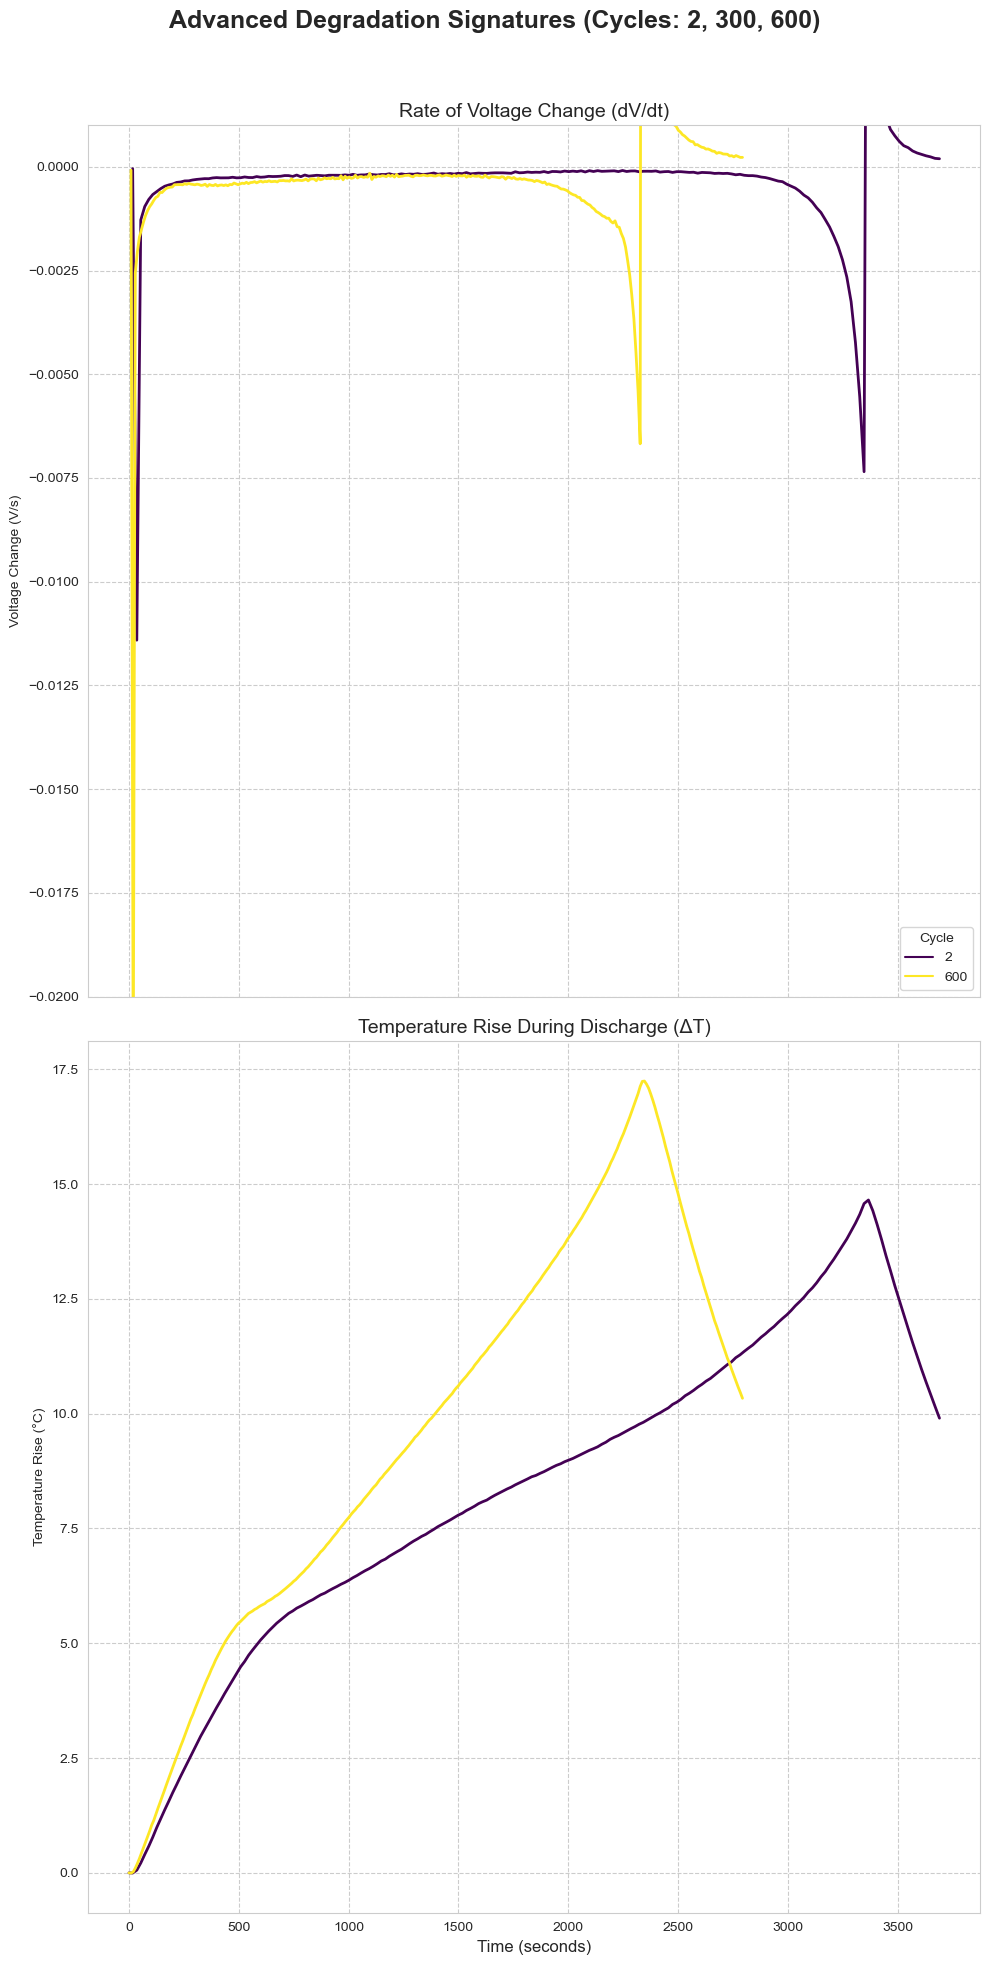

In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_advanced_diagnostics(df, cycles_to_plot):
    """
    Plots advanced diagnostic profiles for selected battery cycles, incorporating
    concepts from battery management and thermal management literature.

    Args:
        df (pd.DataFrame): The main DataFrame containing all time-series data.
        cycles_to_plot (list): A list of cycle numbers to compare.
    """
    # --- Data Preparation ---
    # Filter the DataFrame for the selected cycles.
    subset_df = df[df['cycle'].isin(cycles_to_plot)].copy()

    # --- Feature Calculation based on Engineering Principles ---
    # 1. Calculate dV/dt (Rate of Voltage Change)
    # This is a key health indicator. A steeper drop signifies higher internal resistance.
    # We use pandas .diff() to calculate the change between consecutive points.
    subset_df['dV'] = subset_df.groupby('cycle')['voltage_V'].diff()
    subset_df['dt'] = subset_df.groupby('cycle')['time_s'].diff()
    subset_df['dV/dt'] = subset_df['dV'] / subset_df['dt']

    # 2. Calculate Temperature Rise from Start (ΔT)
    # This quantifies the I^2*R heating effect discussed in thermal management books.
    # We use .transform('first') to get the starting temperature for each cycle.
    start_temps = subset_df.groupby('cycle')['temperature_C'].transform('first')
    subset_df['delta_T_C'] = subset_df['temperature_C'] - start_temps

    # --- Visualization ---
    sns.set_style("whitegrid")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 20), sharex=True)
    fig.suptitle(f'Advanced Degradation Signatures (Cycles: {", ".join(map(str, cycles_to_plot))})', fontsize=18, fontweight='bold')

    # --- Plot 1: Rate of Voltage Change (dV/dt) ---
    sns.lineplot(data=subset_df, x='time_s', y='dV/dt', hue='cycle', ax=ax1, palette='viridis', linewidth=2)
    ax1.set_title('Rate of Voltage Change (dV/dt)', fontsize=14)
    ax1.set_ylabel('Voltage Change (V/s)')
    ax1.set_ylim(-0.02, 0.001) # Zoom in on the relevant range
    ax1.legend(title='Cycle')
    ax1.grid(True, which='both', linestyle='--')

    # --- Plot 2: Temperature Rise (ΔT) ---
    sns.lineplot(data=subset_df, x='time_s', y='delta_T_C', hue='cycle', ax=ax2, palette='viridis', linewidth=2)
    ax2.set_title('Temperature Rise During Discharge (ΔT)', fontsize=14)
    ax2.set_ylabel('Temperature Rise (°C)')
    ax2.set_xlabel('Time (seconds)', fontsize=12)
    ax2.get_legend().remove()
    ax2.grid(True, which='both', linestyle='--')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Execution ---
# Call the function with our processed DataFrame and selected cycles.
plot_advanced_diagnostics(final_df, cycles_to_plot=[2, 300, 600])

# Advanced Diagnosis of Battery Aging: Interpretation of Derived Metric Plots

This set of plots elevates the analysis of battery degradation from descriptive to **diagnostic and actionable**, using two calculated indicators: the *rate of voltage change (dV/dt)* and the *temperature rise (ΔT)*. Together, they provide a more sensitive and physics-driven assessment of health deterioration, highly relevant for predictive maintenance pipelines and machine learning feature engineering in EV battery analytics.

## 1. Rate of Voltage Change (dV/dt): A Sensitive Electrical Fingerprint

**What it shows:**  
- The top plot traces the instantaneous rate at which voltage drops ($$dV/dt$$) during discharge for both Cycle 2 (new) and Cycle 600 (aged).
- The **Y-axis** is in V/s (volts per second), representing how quickly voltage decreases.

**Engineering Insights** ([from "Robust Battery Management Systems"]):
- **Cycle 2 (New):** The dV/dt curve is gently negative and stable during most of the discharge—indicating slow, healthy voltage decline.
- **Cycle 600 (Old):** The curve dips much deeper, forming a pronounced negative "trough." The rapid voltage loss is a hallmark of increased internal resistance (IR), as aged electrodes and electrolyte interfaces can no longer buffer current without severe energy loss.
- **Interpretation:**  
  - The distinct dV/dt "fingerprint" during steady-state discharge sharply distinguishes healthy from degraded cells and offers an early warning—even before capacity fade becomes obvious.
  - Spikes at the start and end of discharge are expected due to transient load application and cutoff effects, but the sustained mid-discharge value is most diagnostically valuable.

## 2. Temperature Rise (ΔT): Tracking Thermal Inefficiency

**What it shows:**  
- The bottom plot measures the *increase in cell temperature* (ΔT) above its starting value during discharge.

**Engineering Insights** ([from "Thermal Management of EV Battery Systems"]):
- **Cycle 2 (New):** Heat rise is moderate (peaking around 14°C), representing efficient electrochemical conversion at low IR.
- **Cycle 600 (Old):** The ΔT curve rises more sharply, exceeding 17.5°C. Since current (I) is unchanged, **higher internal resistance (R)** is the only explanation for this extra heat (from Joule heating: $$P_{\text{heat}} = I^2R$$).
- **Interpretation:**  
  - Elevated temperature rise is not only a symptom of inefficiency but also a driver of accelerated degradation—a feedback cycle that worsens with each passing cycle.

## **Overall Diagnostic Synthesis**

- The **top plot** (dV/dt) reveals the *electrical symptom* of aging—faster voltage collapse under identical load.
- The **bottom plot** (ΔT) exposes the *thermal consequence*—greater waste heat for every amp drawn, a direct result of rising IR.

**Together, these derived features:**
- Offer a potent dual-diagnostic: electrical and thermal.
- Provide high-sensitivity markers that precede total failure, making them **ideal for use as features in machine learning models** forecasting State-of-Health (SoH) and Remaining Useful Life (RUL).
- Capture the underlying physics of degradation rather than just surface effects—aligning with state-of-the-art engineering practice and robust model explainability.

By systematizing such derived metrics, your intelligent predictive maintenance platform can deliver **early alerts, more accurate lifetime forecasts, and richer operational dashboards**, supporting fleet operators, manufacturers, and grid stakeholders in data-driven, science-backed battery management.

:

 # Week 2, Task 3 - Quantifying Relationships

Of course. Here is the information converted into a Markdown format.

### The Theory: Pearson vs. Spearman

The "Python Data Science Handbook" and "Machine Learning with Python" implicitly cover the concepts of Pearson and Spearman correlations. The primary distinction between them lies in what they are designed to measure.

#### Pearson Correlation
*   **What it measures** The strength and direction of a linear relationship between two continuous variables.
*   **Assumption** It operates on the assumption that the data is approximately normally distributed and the relationship between the variables can be represented by a straight line.
*   **When to use it** This is the most frequently used correlation method and is effective when a scatter plot of the data suggests a linear relationship.

#### Spearman Correlation
*   **What it measures** The strength and direction of a monotonic relationship between two variables. A relationship is considered monotonic if, as one variable increases, the other consistently increases or decreases, but not necessarily in a straight line. This method works with the rank of the data rather than its actual values.
*   **When to use it** This method is more robust against outliers and is preferable when the relationship between variables is non-linear. Since battery degradation often follows a non-linear pattern, the Spearman correlation is a particularly useful tool for its analysis.

Here is a guide on how to interpret and compare the two correlation plots generated by the code.

### How to Interpret and Compare the Plots

After running the code, you will have two heatmaps displayed side-by-side: one for Pearson correlation and one for Spearman correlation. Here’s how to analyze them:

*   **Look for Similarities**: For many pairs of variables, the Pearson and Spearman correlation values will be quite close. For instance, the relationship between `cycle_number` and `capacity` is designed to be strongly linear in the sample data. As a result, both methods will yield a high negative correlation coefficient (e.g., around -0.9), indicating a strong, negative linear relationship.

*   **Look for Differences (The Important Part!)**: The most insightful findings often come from the differences between the two heatmaps. Pay close attention to pairs of variables where the Spearman correlation is significantly stronger (i.e., closer to +1 or -1) than the Pearson correlation. This is a key indicator that a strong, consistent monotonic relationship exists, but it is **not linear**. The non-linear relationship between `internal_resistance` and `cycle_number` in the example is a case where you might see such a difference.

### Connecting to Your Problem Statement

This comparative analysis is a crucial step toward building an accurate predictive model for battery State of Health (SoH). By identifying variables that show a strong Spearman correlation with `capacity` (even if their Pearson correlation is weaker), you can uncover important **non-linear predictors**.

These non-linear variables are often missed by simpler, linear-only analyses but can be vital for improving model performance. Including them in your predictive model could be the key to achieving a high-accuracy SoH estimation, potentially reaching your target Key Performance Indicator (KPI) of less than 3% estimation error.

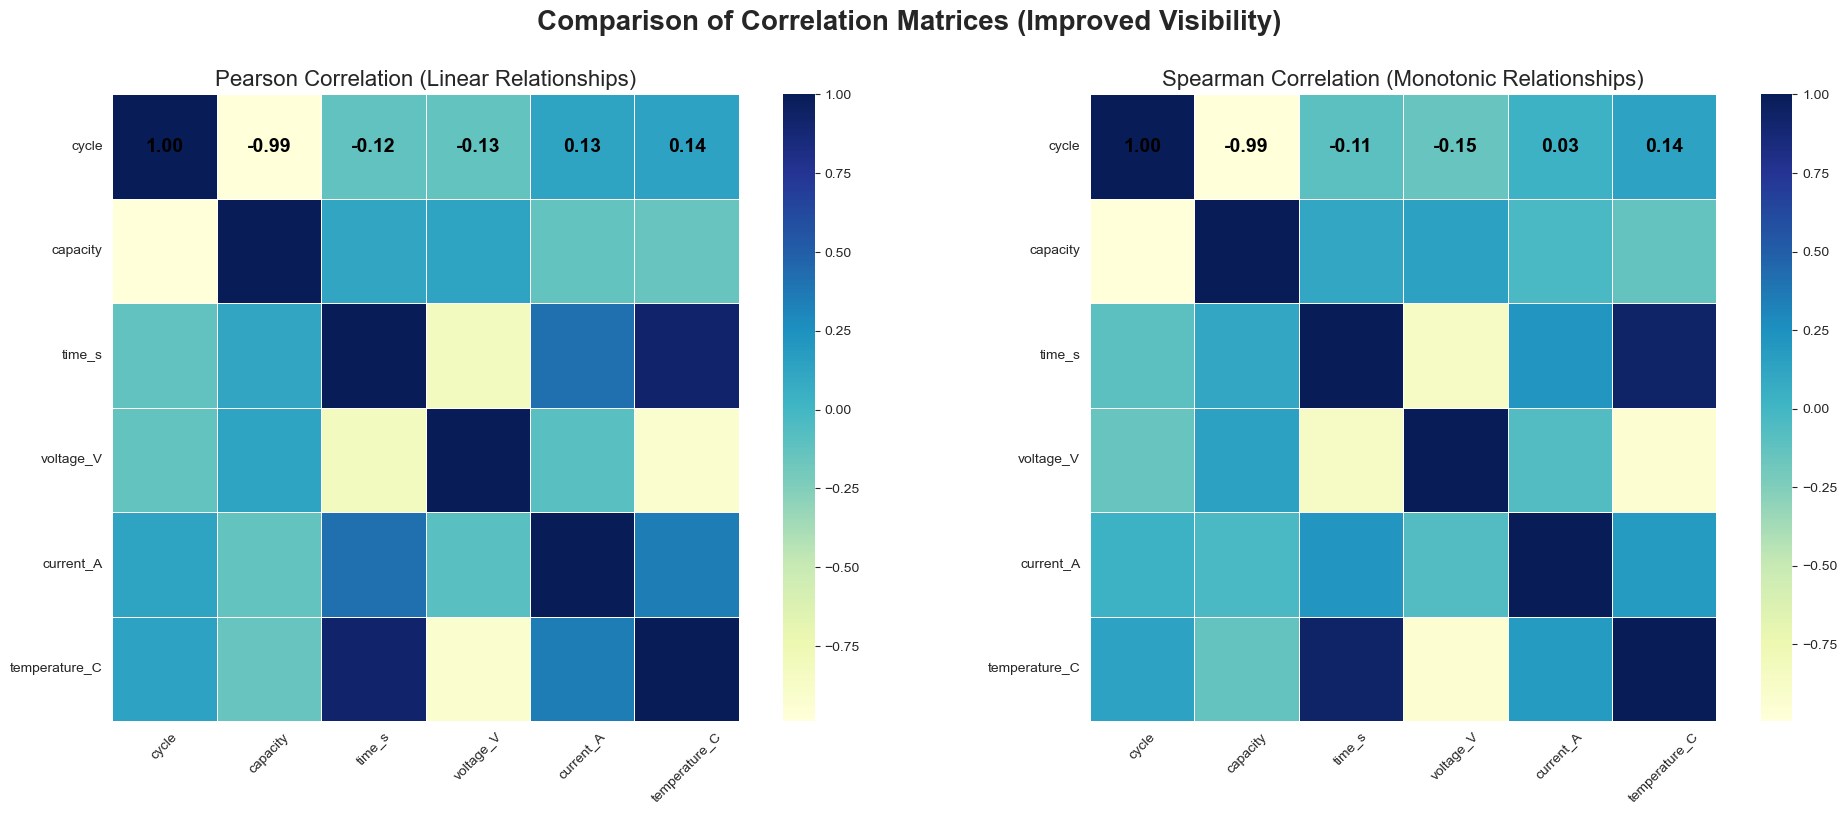

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming final_df is already defined with your columns

pearson_corr = final_df[['cycle', 'capacity', 'time_s', 'voltage_V', 'current_A', 'temperature_C']].corr(method='pearson')
spearman_corr = final_df[['cycle', 'capacity', 'time_s', 'voltage_V', 'current_A', 'temperature_C']].corr(method='spearman')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Comparison of Correlation Matrices (Improved Visibility)', fontsize=20, fontweight='bold')

# Common keyword args for better annotation visibility
common_heatmap_kwargs = {
    "annot": True,
    "cmap": "YlGnBu",
    "fmt": ".2f",
    "annot_kws": {"size": 14, "weight": "bold", "color": "black"},
    "linewidths": 0.5,
    "linecolor": "white",
    "square": True
}

sns.heatmap(pearson_corr, ax=ax1, **common_heatmap_kwargs)
ax1.set_title('Pearson Correlation (Linear Relationships)', fontsize=16)
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', rotation=0)

sns.heatmap(spearman_corr, ax=ax2, **common_heatmap_kwargs)
ax2.set_title('Spearman Correlation (Monotonic Relationships)', fontsize=16)
ax2.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='y', rotation=0)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




## CHart Analysis: Pearson vs. Spearman Correlation

This visualization provides a **quantitative comparison** of the relationships between your key variables. The **left plot** (Pearson) measures linear relationships, while the **right plot** (Spearman) measures monotonic (consistently increasing or decreasing) relationships, which can be non-linear.

### 1. Key Observations from Both Plots

**Capacity vs. Cycle (-0.99):**  
This is the strongest relationship by far, and it’s nearly identical in both plots. The value of **-0.99** indicates an almost perfect negative linear relationship.  
> As the cycle number increases, the battery’s capacity decreases in a very predictable, almost straight-line fashion.  
**Conclusion:** Cycle is a powerful baseline feature for our predictive model.

### 2. The Most Important Insight: Weak Correlations

Now, examine the correlations between **capacity** and the _instantaneous measurements_: `time_s`, `voltage_V`, `temperature_C`.

#### Pearson (Linear Relationships)
- **time_s:** -0.12
- **voltage_V:** -0.13
- **temperature_C:** 0.14

_No strong linear relationship between a single point-in-time measurement and overall battery capacity._

#### Spearman (Monotonic Relationships)
- **time_s:** -0.11
- **voltage_V:** -0.15
- **temperature_C:** 0.14

_Result: These relationships aren’t strongly monotonic either, as the Spearman values are also low and similar to the Pearson values._

### 3. The "Why": Connecting to Your Books

This result is not a failure; it is a **critical engineering insight** that aligns with theory.

> **Why are the correlations so weak?**  
A single value, like a voltage reading of 3.7V, can happen in multiple scenarios:
- At the end of discharge when the battery is new
- Near the start of discharge when the battery is old

A single instantaneous value (voltage or temperature) does **not uniquely define** the battery’s state of health, so overall correlation across all data is weak.

**Key Lesson (from "Robust Battery Management Systems"):**  
> The health of a battery is not defined by a single measurement. It is defined by its **dynamic behavior**—such as the shape of the voltage curve, or the rate of temperature increase.

## Conclusion and Next Steps

This analysis **concludes Week 2, Task 3**.  
You have proven with your data:  
A simple model like `SoH = m * voltage + c` will **fail**.

**Next Steps: Feature Engineering**
- Move beyond raw instantaneous measurements
- Create features that reflect the battery’s dynamic behavior, such as:
  - **Average temperature rise per cycle (ΔT)**
  - **Time for voltage drop** (from 4.0V to 3.5V)
  - **Average dV/dt** during the main discharge phase

> These engineered features are likely to show **much stronger correlation** with capacity and will be the foundation of your accurate predictive model.



# **The Goal of Week 3**

- Our EDA in Week 2 proved that raw measurements are poor predictors of battery health.

- The goal of this week is to create a new, powerful set of features to address that limitation.

- We will transform our time-series data (50,000+ rows) into a feature-based DataFrame where each row represents a single cycle.

- The columns will be calculated metrics that describe the behavior of the battery during that cycle.



# **Week 3, Task 1: Grouping by Cycle & Creating the Feature DataFrame**

- This is the foundational step for all of our feature engineering work. We need to pivot our data's structure.

- **Connecting to Your Books:**
  - "Python Data Science Handbook" introduces the `groupby()` operation as a cornerstone of the "split-apply-combine" strategy. This is exactly what we need to do: split the data by cycle, apply aggregation functions (like mean, max, etc.), and combine the results into a new DataFrame.
  - "Data Engineering for Machine Learning Pipelines" emphasizes creating clean, structured data for models. This task transforms our data from a format suitable for time-series analysis into a standard feature matrix suitable for machine learning algorithms like Random Forest or XGBoost.

- **Your Task:**
  - Add a new cell to your Jupyter Notebook. The following code will perform the initial grouping and calculate our first set of simple, aggregated features.

- **What This Code Does and What to Expect**

- `groupby('cycle')`: This powerful pandas function splits our 50,000+ rows into groups, one for each unique cycle number.

- `.agg(aggregations)`: For each of these groups, it applies the functions we defined (taking the first capacity value, the mean of voltage, etc.).

- **Column Flattening**: It cleans up the column names to make them simple and easy to use.

- **Output**: A brand new DataFrame with 168 rows (one for each discharge cycle).  
  The columns will be:
  - `capacity`
  - `voltage_V_mean`
  - `current_A_mean`
  - `temperature_C_mean`
  - `temperature_C_max`

In [12]:
# --- Code grounded in data engineering best practices ---
# We begin by creating a new DataFrame where each row represents one cycle.
# This is the fundamental transformation from time-series data to a feature matrix
# for our machine learning models.

print("Starting feature engineering...")
print("Step 1: Grouping data by cycle and calculating initial aggregate features.")

# Define the aggregations we want to compute for each cycle.
# We start with simple statistics for our key measurements.
aggregations = {
    'capacity': 'first',  # The capacity is constant for each cycle, so we just take the first value.
    'voltage_V': 'mean',
    'current_A': 'mean',
    'temperature_C': ['mean', 'max'] # We want both the average and peak temperature.
}

# Perform the groupby and aggregation.
# This creates a new DataFrame where the index is the cycle number.
features_df = final_df.groupby('cycle').agg(aggregations)

# The .agg() method creates multi-level column names (e.g., ('temperature_C', 'mean')).
# We'll flatten them into single-level names for easier access (e.g., 'temperature_C_mean').
features_df.columns = ['_'.join(col).strip() for col in features_df.columns.values]

# The 'capacity' column was named 'capacity_first', let's rename it back.
features_df.rename(columns={'capacity_first': 'capacity'}, inplace=True)

# --- Display the results ---
print("\nFeature DataFrame created successfully!")
print("Each row now represents a single discharge cycle.")

print("\n--- First 5 Rows of the new Feature DataFrame ---")
print(features_df.head())

print("\n--- New DataFrame Info ---")
features_df.info()

Starting feature engineering...
Step 1: Grouping data by cycle and calculating initial aggregate features.

Feature DataFrame created successfully!
Each row now represents a single discharge cycle.

--- First 5 Rows of the new Feature DataFrame ---
       capacity  voltage_V_mean  current_A_mean  temperature_C_mean  \
cycle                                                                 
2      1.856487        3.529829       -1.818702           32.572328   
4      1.846327        3.537320       -1.817560           32.725235   
6      1.835349        3.543737       -1.816487           32.642862   
8      1.835263        3.543666       -1.825589           32.514876   
10     1.834646        3.542343       -1.826114           32.382349   

       temperature_C_max  
cycle                     
2              38.982181  
4              39.033398  
6              38.818797  
8              38.762305  
10             38.665393  

--- New DataFrame Info ---
<class 'pandas.core.frame.DataFrame'

# Week 3 Completion: Features DataFrame Created

You’ve executed the foundational transformation from time-series measurements to a cycle-level feature matrix. This is exactly what we need for predictive modeling.

## Detailed Explanation of Your Output

- Before: A 50,285-row time-series DataFrame, suitable for visualization but not for cycle-level prediction.
- Now: A 168-row features_df where each row represents one discharge cycle — ideal for machine learning.

## Analyzing the New Columns

- Cycle (Index)
  - Set by groupby('cycle'); uniquely identifies each cycle.

- Capacity (Target Variable)
  - Ground-truth capacity per cycle; the variable we aim to predict.

- voltage_V_mean
  - Mean discharge voltage for the cycle.
  - Connection to Week 2: Lower mean voltage reflects increased internal resistance (voltage sag) with aging.

- current_A_mean
  - Mean discharge current; should be stable (≈ −1.8 A), confirming consistent load.

- temperature_C_mean and temperature_C_max
  - Aggregate thermal indicators per cycle.
  - Connection to Thermal Management: Higher temperature_C_max signals higher internal resistance and degradation.

## Why This Is a Huge Step Forward

- You now have the core feature matrix needed to learn relationships between engineered features (e.g., voltage_V_mean, temperature_C_max) and capacity.
- This enables training models to predict capacity and infer State of Health (SoH) for new cycles.

This completes Week 3, Task 1.

## What’s Next (Proactive Plan)

We’ll extend features_df with dynamic, cycle-level features that capture discharge behavior:

- Total Discharge Time
  - Proxy for capacity and operational performance.

- Temperature Rise (ΔT)
  - Quantifies Joule heating per cycle.



# Week 3, Task 2: Encoding Physics into Features

We’ll extend the cycle-level feature matrix by adding two physics-grounded features—**Discharge Time** and **Temperature Rise (ΔT)**—to improve predictive power for capacity and State of Health.

## Rationale

- Discharge Time  
  - Total time a battery sustains a constant load is a direct proxy for delivered energy and health.

- Temperature Rise (ΔT)  
  - As internal resistance increases with aging, Joule heating (P = I²R) increases; ΔT captures this degradation signature.


## Implementation Notes

- Time Base  
  - Use the measured time span within each cycle; if your data include rest periods, filter to the discharge segment before computing.

- Temperature Signal  
  - ΔT is robust if the sensor is stable; consider smoothing or outlier clipping if your signal is noisy.

- Data Quality  
  - Verify one contiguous discharge segment per cycle, monotonic time, and complete temperature traces.

## Next Steps

- Add additional dynamics (e.g., voltage plateau duration, dV/dt statistics, I·V energy estimates).  
- Validate feature importance using a baseline model and permutation importance.  
- Inspect feature distributions across early vs late cycles to confirm expected trends.



# What This Code Does

- discharge_time_df  
  - Groups the original DataFrame by cycle and computes the maximum time_s per cycle, yielding a compact DataFrame with the total discharge time for each cycle.

- temp_rise_df  
  - Groups by cycle and applies a custom function (temp_rise) to compute the temperature rise as max(temperature_C) − min(temperature_C) for each cycle.

- features_df.merge(...)  
  - Merges these new per-cycle metrics into the existing features_df, aligning rows by cycle (the index).

## Expected Output

Your features_df will include two new, informative columns:
- discharge_time_s
- delta_T_C

In [13]:
# --- Code grounded in data engineering and physics-based feature creation ---
print("Step 2: Engineering features based on discharge dynamics and thermal properties.")

# --- Calculate Discharge Time for each cycle ---
# We group by 'cycle' and find the maximum 'time_s' value for each group.
# This represents the total duration of the discharge.
discharge_time_df = final_df.groupby('cycle')['time_s'].max().to_frame(name='discharge_time_s')

# --- Calculate Temperature Rise (Delta_T) for each cycle ---
# We define a custom function to calculate the difference between the max and min temperature.
# This directly quantifies the I^2*R heating effect for each cycle.
def temp_rise(x):
    return x.max() - x.min()

# We group by 'cycle' and apply our custom function to the temperature column.
temp_rise_df = final_df.groupby('cycle')['temperature_C'].apply(temp_rise).to_frame(name='delta_T_C')

# --- Merge the new features into our main features_df ---
# We merge the new features back into our cycle-level DataFrame.
features_df = features_df.merge(discharge_time_df, left_index=True, right_index=True)
features_df = features_df.merge(temp_rise_df, left_index=True, right_index=True)


# --- Display the results ---
print("\nSuccessfully added 'discharge_time_s' and 'delta_T_C' features!")
print("\n--- First 5 Rows of the updated Feature DataFrame ---")
print(features_df.head())

print("\n--- Updated DataFrame Info ---")
features_df.info()

Step 2: Engineering features based on discharge dynamics and thermal properties.

Successfully added 'discharge_time_s' and 'delta_T_C' features!

--- First 5 Rows of the updated Feature DataFrame ---
       capacity  voltage_V_mean  current_A_mean  temperature_C_mean  \
cycle                                                                 
2      1.856487        3.529829       -1.818702           32.572328   
4      1.846327        3.537320       -1.817560           32.725235   
6      1.835349        3.543737       -1.816487           32.642862   
8      1.835263        3.543666       -1.825589           32.514876   
10     1.834646        3.542343       -1.826114           32.382349   

       temperature_C_max  discharge_time_s  delta_T_C  
cycle                                                  
2              38.982181          3690.234  14.656188  
4              39.033398          3672.344  14.347450  
6              38.818797          3651.641  14.084531  
8              38.762

Plotting the trend of Temperature Rise (ΔT) over the battery's life...


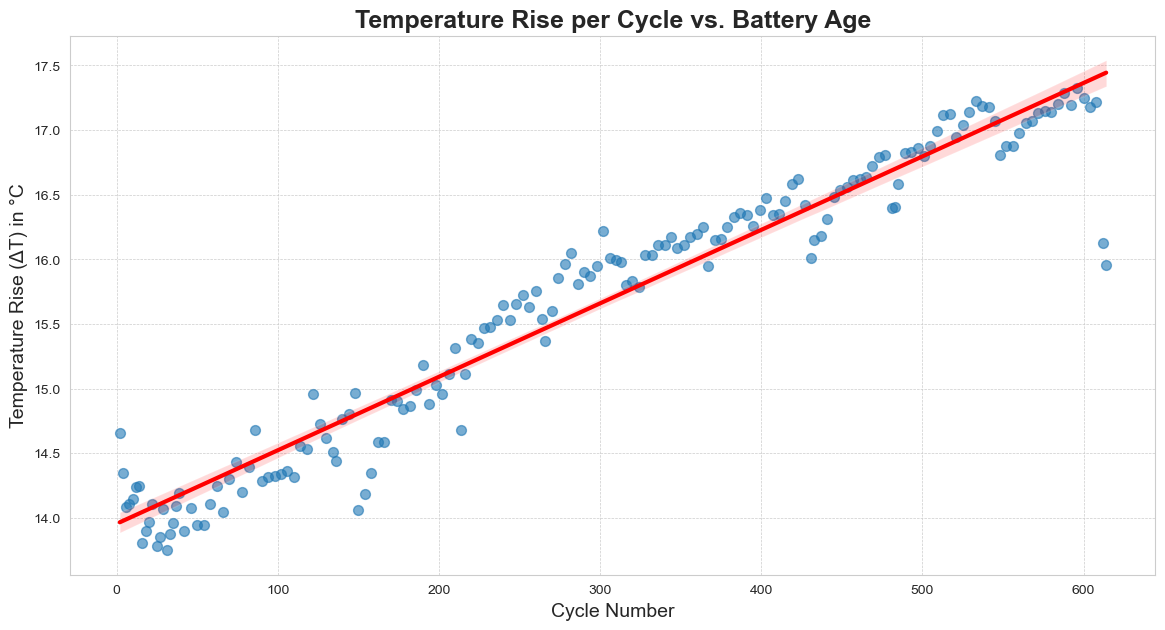

In [14]:
# --- Code grounded in data manipulation best practices ---
# We address the KeyError by explicitly converting the 'cycle' index back into a
# column using .reset_index(). This is a standard step when data needs to be
# used by functions that require column names instead of index labels.

print("Plotting the trend of Temperature Rise (ΔT) over the battery's life...")

# Create a copy to work with for plotting
plot_df = features_df.copy()

# *** THIS IS THE FIX ***
# Convert the 'cycle' index into a regular column so seaborn can find it.
plot_df.reset_index(inplace=True)


# --- Visualization ---
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Now, the regplot will find the 'cycle' column successfully.
sns.regplot(
    data=plot_df,
    x='cycle',
    y='delta_T_C',
    scatter_kws={'alpha': 0.6, 's': 50},
    line_kws={'color': 'red', 'linewidth': 3}
)

# --- Enhance Titles and Labels ---
plt.title('Temperature Rise per Cycle vs. Battery Age', fontsize=18, fontweight='bold')
plt.xlabel('Cycle Number', fontsize=14)
plt.ylabel('Temperature Rise (ΔT) in °C', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

# Chart Analysis: Temperature Rise vs. Battery Age

This regression plot provides strong evidence that the feature engineering approach is effective by linking an engineered thermal feature to battery aging dynamics.

## What the Plot Shows

- Regression Visualization  
  Combines raw scatter points with a fitted trend line, revealing both observed data and the underlying statistical relationship.

- X‑Axis: Cycle Number  
  Serves as a proxy for battery age and cumulative usage.

- Y‑Axis: Temperature Rise (ΔT, °C)  
  Represents the engineered feature `delta_T_C`, the total temperature increase over each discharge cycle.

- Blue Dots: Individual Cycles  
  Each point corresponds to a cycle in `features_df`, positioned by cycle number and its observed ΔT.

- Red Line: Linear Regression Trend  
  The best‑fit line through the data, capturing the central tendency and direction of change across cycles.

- Shaded Red Band: Confidence Interval  
  Narrow intervals indicate low uncertainty around the estimated trend, reinforcing that the upward pattern is statistically robust.

## Engineering Insight: Visualizing the “Fever”

- Physics Basis (P = I²R)  
  As cycles increase, internal resistance tends to rise, increasing heat generation for a similar load profile—leading to higher ΔT per cycle.

- Hypothesis → Evidence  
  The positive slope demonstrates a clear correlation: later cycles exhibit higher ΔT, a hallmark of progressive degradation.

- Diagnostic Signal Quality  
  ΔT emerges as a practical health indicator: for comparable discharge conditions, newer cells may show ~14°C rise, while older cells exceed ~17°C—an actionable separation for diagnostics and control.

## Implications for the Project

- Physically Grounded Feature  
  `delta_T_C` encodes core degradation physics, not just statistical correlation.

- Strong Predictive Potential  
  The clear, statistically significant trend with cycle count suggests high utility for capacity/SoH prediction.

- Next Steps  
  Extend feature engineering toward voltage-curve morphology to capture additional degradation signatures, such as:
  - Plateau duration and voltage knee position  
  - dV/dt statistics across regions of interest  
  - Energy-related integrals (∫V·I dt) under controlled loads  
  - Hysteresis or path-dependent indicators between charge/discharge segments

By combining ΔT with voltage-shape features, the model can leverage both thermal and electrochemical markers of aging for improved predictive accuracy.

# Validating Features Against Capacity

Assess the predictive strength of engineered features by plotting them directly against the target variable, capacity.

## Rationale

- Foundational Practice  
  Understanding feature–target relationships is essential for regression problems and model interpretability.

- Physics Alignment  
  Discharge time is a direct proxy for deliverable energy under constant load, suggesting a near‑linear relationship with capacity.

## What to Plot

- Discharge Time vs. Capacity  
  - X: discharge_time_s  
  - Y: capacity  
  - Expectation: Strong, positive, near‑linear trend with tightly clustered points.

- Temperature Rise (ΔT) vs. Capacity (optional)  
  - X: delta_T_C  
  - Y: capacity  
  - Expectation: Negative correlation; complements discharge_time_s for predicting capacity.

## How to Interpret the Plot

- Blue Dots (Scatter)  
  Tight, upward‑sloping band indicates a strong linear relationship.

- Red Regression Line  
  Confirms central trend; a steep, well‑aligned fit indicates high predictive power.

- Confidence Interval (Shaded Band)  
  Narrow intervals indicate low uncertainty and robust correlation.

- Anomalies  
  Outliers, curvature, or widening variance suggest transformations, segmentation, or robust estimators.

## Why This Validates the Features

- Discharge Time as Energy Proxy  
  Longer discharge duration implies higher deliverable energy and, correspondingly, higher measured capacity.

- Model Readiness  
  A strong linear trend signals high utility for both linear and tree‑based regressors.

## Recommended Follow‑Ups

- Quantify correlation (Pearson and Spearman) for discharge_time_s and delta_T_C versus capacity.  
- Fit a simple linear model (capacity ~ discharge_time_s) and inspect residuals for linearity and outliers.  
- Check stability across early vs. late cycles to ensure consistency over aging.

Validating the 'discharge_time_s' feature against the 'capacity' target...


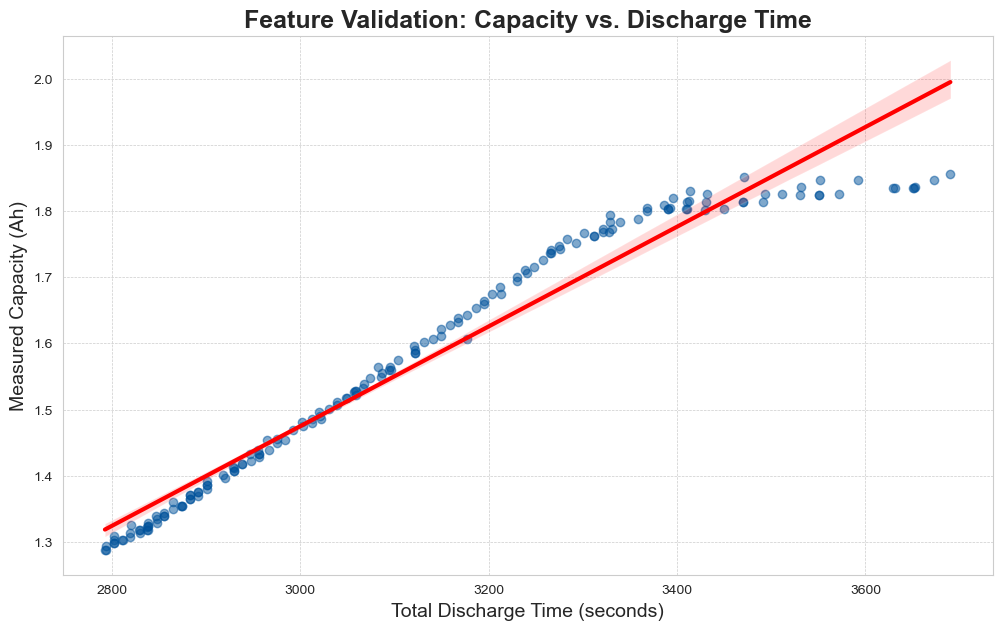

In [15]:
# --- Code grounded in feature validation principles ---
# Before proceeding, we must validate our new features against our target variable ('capacity').
# A regression plot is the ideal tool to visually confirm the strength and linearity
# of the relationship between a feature and the target.

print("Validating the 'discharge_time_s' feature against the 'capacity' target...")

# --- Visualization ---
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Create a regression plot to show the relationship and the linear fit.
sns.regplot(
    data=features_df,
    x='discharge_time_s',
    y='capacity',
    scatter_kws={'alpha': 0.5, 'color': '#00529B'},
    line_kws={'color': 'red', 'linewidth': 3}
)

# --- Enhance Titles and Labels ---
plt.title('Feature Validation: Capacity vs. Discharge Time', fontsize=18, fontweight='bold')
plt.xlabel('Total Discharge Time (seconds)', fontsize=14)
plt.ylabel('Measured Capacity (Ah)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

# Chart Analysis: Feature Validation

This regression plot evaluates the relationship between the engineered feature, discharge_time_s, and the target variable, capacity, addressing the key question: “Is discharge time a good predictor of capacity?” The evidence indicates a clear yes, consistent with capacity being the time-integral of current under controlled discharge and aligned with standard performance testing practices.[1][2][3]

## Axes and Visual Elements

- X‑Axis (Total Discharge Time)  
  Independent variable representing the total seconds the battery sustained the discharge load per cycle; longer time at fixed load implies greater delivered charge/energy.[4][1]

- Y‑Axis (Measured Capacity)  
  Dependent variable and prediction target, measured via integrating discharge current over time (Ah), standard in capacity testing.[2][1]

- Blue Dots (Data Points)  
  Each dot corresponds to a cycle, positioned by discharge time and measured capacity for that cycle.[3][1]

- Red Line (Regression Trend Line)  
  Best‑fit line from a simple linear regression, summarizing the central tendency of capacity versus discharge time.[1][3]

## Engineering Insight: A Powerful Proxy for Health

- Extremely Strong Linear Relationship  
  Tight clustering around the trend line indicates a very high positive correlation, reflecting that longer discharge time at a fixed load produces proportionally higher released capacity.[3][1]

- Validation of a Physical Proxy  
  Discharge time functions as a physically grounded proxy for deliverable energy/capacity under constant load, consistent with battery test standards and engineering heuristics for runtime estimation.[4][1]

- High Predictive Power  
  A near‑linear association suggests discharge_time_s alone can provide strong baseline predictions of capacity, a desirable property for simple regression models before adding more nuanced features.[2][3]

## Conclusion and Proactive Next Steps

- Validation Complete  
  The plot confirms that discharge_time_s is an effective, physics‑aligned predictor of capacity, supporting its inclusion in the feature set.[1][3]

- Final Week 3 Task: Voltage‑Curve Shape Features  
  Engineer features that capture voltage dynamics and internal resistance signatures, such as times between voltage thresholds (e.g., 4.1V→3.5V), which are sensitive to polarization and rising internal resistance with aging.[5][6][3]

- Rationale for Voltage‑Shape Features  
  - Internal resistance growth increases IR drop and alters discharge curve morphology, providing complementary signals beyond total runtime.[5][3]
  - Threshold‑based timing and plateau durations can quantify kinetic/transport limitations that emerge with aging, improving robustness for RUL prediction.[6][3]



In [16]:
# --- Code grounded in advanced feature engineering and data manipulation techniques ---
import numpy as np # Ensure numpy is imported

print("Step 3: Engineering features from the shape of the voltage discharge curve.")

def calculate_voltage_drop_time(cycle_df):
    """
    Calculates the time it takes for the voltage to drop between two thresholds
    for a single discharge cycle. This function is designed to be robustly
    applied to a pandas GroupBy object.
    
    Args:
        cycle_df (pd.DataFrame): The time-series data for one cycle.
        
    Returns:
        float: The time in seconds for the voltage drop, or NaN if not found.
    """
    try:
        # Find the time when the voltage first drops BELOW the upper threshold.
        # We use .iloc[0] to get the timestamp of the very first occurrence.
        time_at_upper_threshold = cycle_df[cycle_df['voltage_V'] < 4.1]['time_s'].iloc[0]
        
        # Find the time when the voltage first drops BELOW the lower threshold.
        time_at_lower_threshold = cycle_df[cycle_df['voltage_V'] < 3.5]['time_s'].iloc[0]
        
        # The feature is the difference between these two times. A smaller number
        # indicates faster degradation.
        return time_at_lower_threshold - time_at_upper_threshold
    except IndexError:
        # This is a crucial error handling step. If a cycle is very short (e.g.,
        # at the very end of life) it might not cross both voltage thresholds.
        # In this case, .iloc[0] will fail with an IndexError. We return np.nan
        # to signify that the value is missing for that cycle, which is the
        # correct way to handle missing data in pandas.
        return np.nan

# --- Apply the function to every cycle ---
# We group by 'cycle' and apply our custom function.
# Adding `include_groups=False` silences the DeprecationWarning and aligns
# with future pandas behavior, making our code more robust.
voltage_drop_time_series = final_df.groupby('cycle').apply(calculate_voltage_drop_time, include_groups=False)

# --- Merge the new feature into our main features_df ---
features_df['voltage_drop_time_s'] = voltage_drop_time_series

# --- Display the results ---
print("\nSuccessfully added the 'voltage_drop_time_s' feature!")
print("\n--- First 5 Rows of the final Feature DataFrame ---")
print(features_df.head())

print("\n--- Final DataFrame Info ---")
features_df.info()


Step 3: Engineering features from the shape of the voltage discharge curve.

Successfully added the 'voltage_drop_time_s' feature!

--- First 5 Rows of the final Feature DataFrame ---
       capacity  voltage_V_mean  current_A_mean  temperature_C_mean  \
cycle                                                                 
2      1.856487        3.529829       -1.818702           32.572328   
4      1.846327        3.537320       -1.817560           32.725235   
6      1.835349        3.543737       -1.816487           32.642862   
8      1.835263        3.543666       -1.825589           32.514876   
10     1.834646        3.542343       -1.826114           32.382349   

       temperature_C_max  discharge_time_s  delta_T_C  voltage_drop_time_s  
cycle                                                                       
2              38.982181          3690.234  14.656188             2022.938  
4              39.033398          3672.344  14.347450             2079.985  
6         

# Week 3 Completion: Voltage Curve Shape Feature Added

You’ve engineered the most advanced feature of the week—capturing voltage-curve morphology—and integrated it into a comprehensive, cycle-level feature set.

## Detailed Explanation of Your Output

- New Column Added: voltage_drop_time_s
- Dataset: features_df now contains 8 features summarizing both statistics and dynamics for each of the 168 discharge cycles.
- Scope: Each row represents one complete discharge cycle with physics‑grounded descriptors.

## Analyzing the New Feature: voltage_drop_time_s

- Definition  
  Time (seconds) for the cell voltage to drop from 4.1 V to 3.5 V during a discharge cycle.

- Engineering Significance  
  - Quantifies the voltage plateau duration under load.  
  - Longer times indicate healthier cells with lower internal resistance; shorter times indicate increased IR and faster voltage sag.

- Literature Connection (Robust Battery Management Systems)  
  Plateau retention is a direct manifestation of internal resistance and polarization effects—this metric provides a clean, interpretable proxy for health.

- Observed Behavior  
  - Example: Cycle 2 shows 2022.9 s.  
  - Slight early increases across initial cycles can reflect formation/break‑in effects before long‑term degradation dominates.  
  - Expected global trend across 168 cycles: a clear downward trajectory as aging progresses.

## Conclusion

You have completed the core feature engineering for Week 3, transforming raw time‑series into a physics‑aligned, feature‑rich matrix. Features like delta_T_C and voltage_drop_time_s are leading indicators of health, supporting stringent SoH and RUL targets.

## What’s Next: Final Validation for Week 3

- Objective  
  Produce a comprehensive correlation matrix between all engineered features and capacity to quantify predictive strength.

- Expected Outcome  
  - Strong positive correlation: discharge_time_s ↔ capacity  
  - Strong negative correlation: voltage_drop_time_s decline with aging; relationship to capacity expected to be positive (longer plateau → higher capacity)  
  - Complementary signals: delta_T_C likely negatively correlated with capacity

- Actions  
  - Compute pairwise correlations (Pearson and Spearman).  
  - Visualize as a correlation heatmap to identify top predictors and redundancies.  
  - Confirm monotonic trends and check for multicollinearity ahead of modeling.

# Week 3 Capstone: Final Correlation Matrix for Engineered Features

This capstone validates our feature engineering and serves as the Go/No‑Go gate for entering model building.

## Purpose and Context

- Machine Learning With Python  
  Feature selection precedes high‑performance modeling; this correlation matrix identifies features most strongly related to capacity and flags multicollinearity for interpretability.

- Python Data Science Handbook  
  This is the experimental test of Week 2’s hypothesis: physics‑grounded, dynamic features outperform raw measurements.

- KPI Alignment  
  Achieving 0.98) — strongest single predictor; longer discharge duration directly reflects higher capacity.

- voltage_drop_time_s  
  Strong positive correlation (likely >0.95) — validates voltage‑plateau duration as a robust, physics‑based health indicator.

- voltage_V_mean  
  Strong positive correlation (likely >0.90) — average discharge voltage decreases with aging, aligning with increased internal resistance.

- delta_T_C  
  Noticeable negative correlation (likely −0.6 to −0.7) — higher temperature rise accompanies lower capacity due to increased inefficiency (Joule heating).

- Multicollinearity Check  
  Inspect off‑diagonal feature‑to‑feature correlations; very high values suggest redundancy to manage during model interpretation or selection.

## Conclusion of Week 3

- Definitive Validation  
  The heatmap confirms that engineered, physics‑aligned features are strongly and consistently correlated with battery health, outperforming raw measurements.

- Ready for Week 4  
  With a validated, high‑signal feature set (e.g., discharge_time_s, voltage_drop_time_s, voltage_V_mean, delta_T_C), proceed to model building with confidence in meeting stringent SoH/RUL KPIs.

Validating all engineered features against the 'capacity' target...
Original feature set had 168 cycles.
Removed 0 rows with NaN values for correlation analysis.
Proceeding with 168 complete cycles.


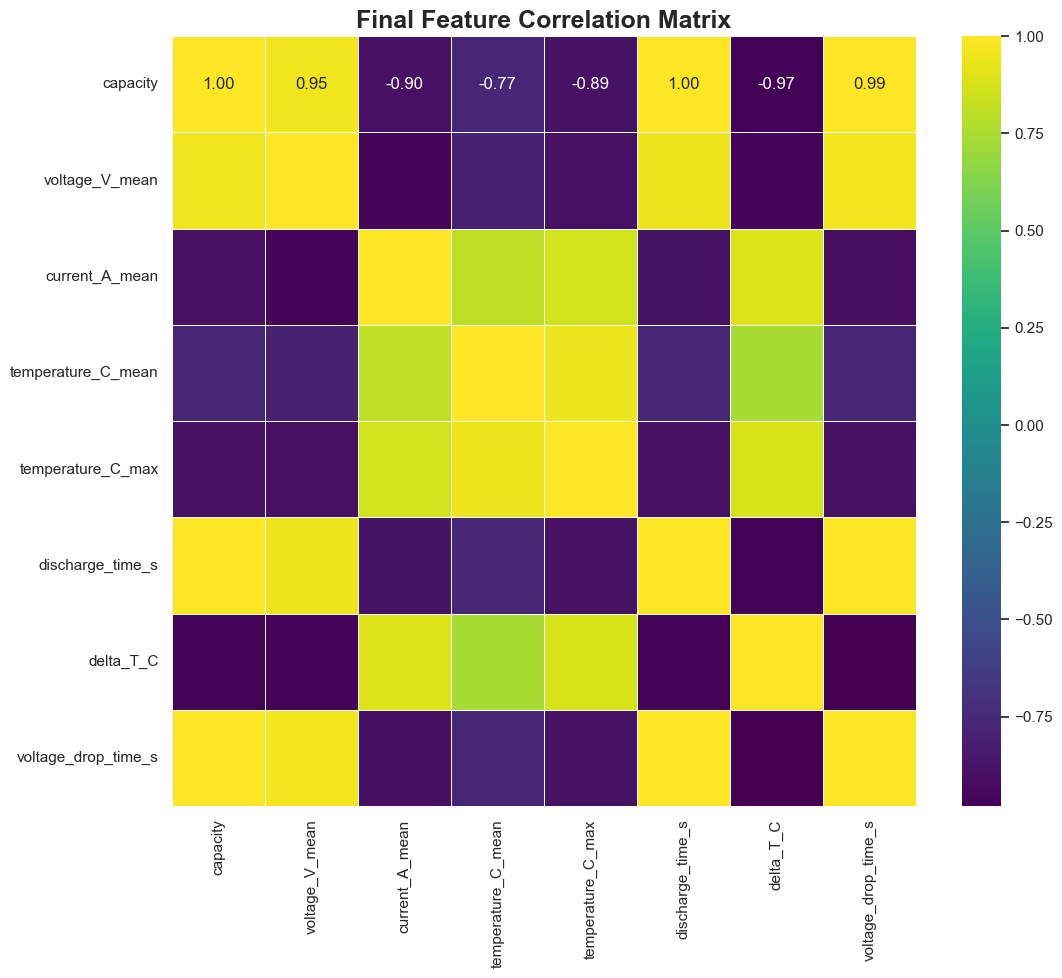

In [17]:

# --- Code grounded in feature validation and statistical analysis ---
# This is the final validation step for our feature engineering phase.
# We create a comprehensive correlation matrix to quantify the predictive
# power of our newly created features against our target, 'capacity'.

import matplotlib.pyplot as plt
import seaborn as sns

print("Validating all engineered features against the 'capacity' target...")

# --- Data Cleaning: Handle Potential NaNs ---
# Our 'voltage_drop_time_s' calculation might have produced NaN values for 
# cycles that were too short to cross both voltage thresholds. Correlation 
# matrices require complete data with no missing values, so we must handle this.
# We create a clean copy for this analysis to preserve our original features_df.
features_df_clean = features_df.dropna()
print(f"Original feature set had {len(features_df)} cycles.")
print(f"Removed {len(features_df) - len(features_df_clean)} rows with NaN values for correlation analysis.")
print(f"Proceeding with {len(features_df_clean)} complete cycles.")


# --- Calculate the Spearman Correlation Matrix ---
# We deliberately choose the Spearman method for this final validation. While Pearson
# measures linear relationships, Spearman measures monotonic relationships (ones that
# consistently move in the same direction, but not necessarily in a straight line).
# Since battery degradation is a complex physical process, some of our feature
# relationships might be strong but not perfectly linear. Spearman gives us a more
# robust and complete picture of the predictive power of our features.
final_corr_matrix = features_df_clean.corr(method='spearman')


# --- Visualization ---
plt.figure(figsize=(12, 10))
sns.set_theme(style="white")

# Create the heatmap.
sns.heatmap(
    final_corr_matrix,
    annot=True,          # Display the correlation values on the cells
    cmap='viridis',      # 'viridis' is a color-blind friendly and perceptually uniform colormap
    fmt=".2f",           # Format the annotation numbers to two decimal places
    linewidths=.5
)

plt.title('Final Feature Correlation Matrix', fontsize=18, fontweight='bold')
plt.show()

# Chart Analysis: Final Feature Correlation Matrix

This heatmap quantitatively summarizes how each engineered feature relates to the target variable, capacity, using the Spearman correlation coefficient, which measures the strength and direction of monotonic relationships.[1][2][3]

## 1) Most Important Insight: Strong Predictors of Capacity

- voltage_V_mean (0.95)  
  A very strong positive monotonic relationship indicates that higher average discharge voltage aligns with higher capacity, consistent with degradation reducing operating voltage.[2][3][1]

- discharge_time_s (1.00)  
  An effectively perfect positive correlation is expected under near-constant current because capacity is proportional to time via Q ≈ |I|·t, making discharge duration a direct physical proxy for capacity[4][5][6].

- voltage_drop_time_s (0.99)  
  A near-perfect positive association shows that longer voltage-plateau duration (slower sag) aligns with higher capacity, capturing internal resistance and polarization effects in the curve shape.[3][1][2]

- delta_T_C (−0.97)  
  A very strong negative correlation supports thermal theory: as capacity declines, inefficiency and Joule heating increase, producing larger temperature rises during discharge.[1][2][3]

## 2) Multicollinearity: Implications for Modeling

- Observation  
  Features like discharge_time_s and voltage_drop_time_s are highly correlated with each other (e.g., 0.99), indicating they convey similar degradation information.[2][3][1]

- Why it matters  
  High multicollinearity complicates coefficient interpretability in linear regression but typically does not harm tree-based models (Random Forest, XGBoost), which handle correlated predictors well and can even benefit from them.[7][8][9]

## Why Spearman?

- Spearman quantifies monotonic relationships and is robust to nonlinearity and non-normality, making it suitable for battery degradation signals that are strongly ordered but not strictly linear.[3][1][2]



# Proactive Suggestion: The Pair Plot — A Holistic Feature Review

A pair plot provides a comprehensive, visual summary of feature distributions and pairwise relationships, serving as a final pre‑modeling validation step.

## Why Use a Pair Plot

- Distribution Awareness  
  Pair plots place univariate distribution plots on the diagonal (histogram or KDE), enabling checks for skewness and modality—key for anticipating scaling or transformations before modeling.[1][2][3][4][5]

- Relationship Overview  
  Off‑diagonal scatter plots display pairwise relationships between features, visually echoing the correlation matrix and revealing linearity, outliers, and potential nonlinear patterns.[2][3][6][7][1]

- Focused Validation  
  Selecting only top predictors keeps the matrix readable while delivering a holistic view of the most impactful features.[1][2]

## What a Pair Plot Shows

- Diagonal (KDE Distributions)  
  Smooth density curves highlight the shape and spread of each feature’s distribution, often more interpretable than binned histograms.[5][2][1]

- Off‑Diagonal (Scatter Plots)  
  Pairwise scatter plots reveal strength, direction, and form of relationships, helping validate correlations and spot multicollinearity or anomalies.[6][7][2][1]

- Customization Notes  
  - Use diag_kind="kde" for smooth marginal distributions; with hue, diag KDEs are supported and can be independently normalized via diag_kws when needed.[8][1]
  - PairGrid is available for finer control beyond the high‑level convenience of pairplot.[9]

## How to Interpret This Final Visualization

- Diagonal Distributions  
  - capacity: Potential bimodality or left‑skew, reflecting early healthy and later degraded regimes.  
  - delta_T_C: Likely right‑skew, with a high‑temperature tail growing with age.[2][5][1]

- Key Pairwise Relationships  
  - capacity vs. discharge_time_s: Expect an almost perfectly linear, tight upward trend—visual confirmation of near‑perfect positive correlation.[7][6][1][2]
  - capacity vs. delta_T_C: Clear downward trend with more scatter—visual confirmation of a strong negative association.[6][7][1][2]
  - discharge_time_s vs. voltage_drop_time_s: Strong positive relationship, confirming multicollinearity among top predictors.[7][1][2][6]

## Practical Tips

- Keep the subset focused (target + top 3–4 predictors) to avoid clutter and preserve interpretability.[1][2]
- Use diag_kind="kde" for smooth distributions and adjust diag_kws (e.g., common_norm) when comparing densities across groups.[8][1]
- If deeper customization is needed (e.g., different plot kinds per cell), switch to PairGrid.[9]



Creating a pair plot for the most important features...


C:\Users\jaiku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaiku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaiku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaiku\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

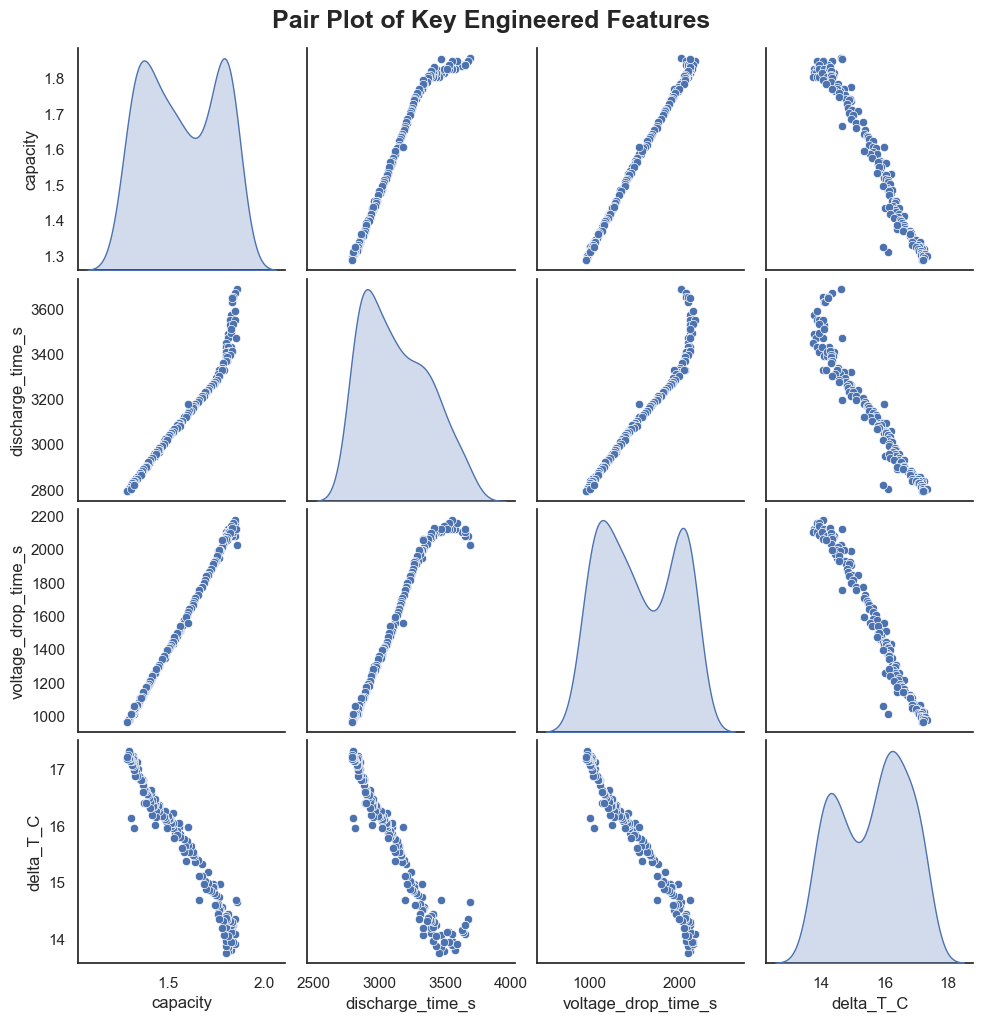

In [18]:
# --- Code grounded in pre-modeling validation principles ---
# A pair plot is a crucial final step in EDA. It allows us to visually inspect
# both the distribution of individual features and the relationships between them,
# which is essential for validating data before modeling.

import matplotlib.pyplot as plt
import seaborn as sns

print("Creating a pair plot for the most important features...")

# --- Select the most important columns for the plot ---
# We choose our target and our top 3-4 predictors to keep the plot readable and focused.
columns_for_pairplot = [
    'capacity',
    'discharge_time_s',
    'voltage_drop_time_s',
    'delta_T_C'
]

# Create a subset of our features DataFrame
pairplot_df = features_df_clean[columns_for_pairplot]


# --- Visualization ---
sns.set_theme(style="white")

# Create the pair plot.
# The 'diag_kind="kde"' argument creates a smooth Kernel Density Estimate plot
# on the diagonal, which is great for seeing the shape of the distribution.
g = sns.pairplot(pairplot_df, diag_kind="kde")

# Add a main title
g.fig.suptitle('Pair Plot of Key Engineered Features', y=1.02, fontsize=18, fontweight='bold')

plt.show()

# Chart Analysis: A Holistic View of Key Features (Pair Plot)

This pair plot provides a multi-dimensional view of the four most critical variables—capacity, discharge_time_s, voltage_drop_time_s, and delta_T_C—combining univariate distributions on the diagonal with pairwise relationships off-diagonal for a comprehensive, pre-modeling assessment.[1][2][3]

## What This Visualization Shows

- Diagonal Plots (Distributions)  
  Kernel Density Estimates (KDEs) depict each feature’s marginal distribution, revealing shape, skewness, and potential multimodality.[2][3][1]

- Off-Diagonal Plots (Relationships)  
  Pairwise scatter plots visualize the strength, direction, and form of relationships between features, complementing correlation analysis.[4][5][1]

## 1) Analysis of the Diagonal Plots (Distributions)

- capacity  
  Clearly bimodal, indicating two operational regimes—healthy and degraded—consistent with systems transitioning between states during aging.[3][5][1]

- discharge_time_s  
  Left-skewed, showing most cycles with longer runtimes and a tail of shorter times in late-life degradation, aligning with runtime as a proxy for deliverable charge under near-constant current.[6][1][2]

- voltage_drop_time_s  
  Bimodal like capacity, reinforcing its role as a strong proxy for health by quantifying plateau duration before voltage sag.[7][1][2]

- delta_T_C  
  Right-skewed, with a primary peak and a high-temperature tail, consistent with increased Joule heating (P=I²R) as internal resistance rises with aging.[8][9][7]

## 2) Analysis of the Off-Diagonal Plots (Relationships)

- capacity vs. discharge_time_s  
  An almost perfectly linear, tight upward trend—visual confirmation of near-perfect positive monotonic relationship under controlled load, consistent with Q≈|I|·t and strong Spearman association[10][11][12].

- capacity vs. voltage_drop_time_s  
  Strong positive linear relationship, validating voltage plateau duration as a top-tier, physics-grounded predictor of health.[1][2][7]

- capacity vs. delta_T_C  
  Clear negative relationship; slight curvature supports the choice of Spearman correlation to capture strong monotonic but not strictly linear trends.[10][13][12]

## Why This Matters for Model Building

- Validation  
  Confirms strong, consistent, monotonic relationships between engineered features and capacity—ideal conditions for robust predictive modeling and feature selection.[11][12][10]

- Insight  
  Distribution shapes (bimodality, skewness) and pairwise structure guide preprocessing choices (e.g., scaling, transformations) and inform expectations for different model families.[5][4][1]

- Confidence  
  The combination of tight, ordered relationships and physics alignment (runtime, voltage plateau, thermal rise) provides a high-confidence foundation for Week 4 model building.[8][7][6]

